# Parametric Circuit Fitting Belem

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def fit_model(filename, rank, ratio = None, ):
    inputs_map, targets_map, inputs_spam, targets_spam =  pickle.load(open(f"../../data/{filename}", "rb"))
    
    d = targets_map.shape[1]
    n = int(np.log2(d))
    
    if ratio is not None:
        inputs_map, targets_map, _, _ = train_val_split(inputs_map, targets_map, ratio=ratio)
    
    spam = SPAM(init = InitialState(d, c=None),
                povm = CorruptionMatrix(d, c=None),
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(num_iter = 300)
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 4000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=rank,
                                                   spam = spam,
                                                  ),
                               loss_function = KLDiv(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = KLDiv(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 4000,
                )
    return model

In [3]:
def spectrum_to_radial(spectrum):
    radial = tf.norm(spectrum, axis=1)
    return radial

def spectrum_to_angular(spectrum):
    angular = tf.math.angle(spectrum[:-1,0] + 1j*spectrum[:-1,1])
    return angular

def angular_histogram(spectrum_list, bins, color="b"):
    angular_list = [spectrum_to_angular(spectrum) for spectrum in spectrum_list]
    angular = np.concatenate(angular_list)
    plt.hist(angular, bins, color=color)

def find_outer_inner_R(spectrum_list):
    L = len(spectrum_list)
    radial_list = np.array([np.sort(spectrum_to_radial(spectrum)) for spectrum in spectrum_list])
    R_minus = np.mean(radial_list[:,0])
    R_minus_std = np.std(radial_list[:,0])
    R_plus = np.mean(radial_list[:,-1])
    R_plus_std = np.std(radial_list[:,-1])
    return R_plus, R_minus, R_plus_std, R_minus_std

## Three Qubits

In [8]:
model_list1 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_8layers{i}",  64)
    model_list1.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001327653820968952


  0%|          | 0/4000 [00:00<?, ?it/s]

0.003551409082235411 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011824960783093003


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0018747940288835483 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001184040567812827


  0%|          | 0/4000 [00:00<?, ?it/s]

0.003285918956985967 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012388296482775877


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0029357188109703967 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012818300433524888


  0%|          | 0/4000 [00:00<?, ?it/s]

7.365500140773344e-05 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011069106794969195


  0%|          | 0/4000 [00:00<?, ?it/s]

0.000767250578026686 None


In [9]:
model_list2 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_16layers{i}",  64)
    model_list2.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011663376745526146


  0%|          | 0/4000 [00:00<?, ?it/s]

8.697400748443898e-05 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0010027210085565802


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0009022824553927817 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011422157996590285


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002825440380509696 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0015125616861830062


  0%|          | 0/4000 [00:00<?, ?it/s]

0.00396238285998384 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011682327607535836


  0%|          | 0/4000 [00:00<?, ?it/s]

0.00035404068240788255 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012521459769997965


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0031067522591823184 None


In [10]:
model_list3 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_24layers{i}",  64)
    model_list3.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012271322153052423


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0018609493064393452 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001207853608911101


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0017760362382267794 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.00108140870330553


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0028173587256747025 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.002093979631638645


  0%|          | 0/4000 [00:00<?, ?it/s]

0.004472959042072389 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0010509059683612325


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0007178582202542672 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0029058379036469746


  0%|          | 0/4000 [00:00<?, ?it/s]

0.004075445999745191 None


In [11]:
model_list4 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_32layers{i}",  64)
    model_list4.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0049636064818597714


  0%|          | 0/4000 [00:00<?, ?it/s]

0.013081375234492404 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004576820358722299


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0007126694097882204 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004961535539572094


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0001353977503524093 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005776078217396701


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011270553680022002 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004400454716407359


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.002266208822979474 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0049548095435964215


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.00015593497186041722 None


In [12]:
model_list5 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_40layers{i}",  64)
    model_list5.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005020498771338718


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.002894157997346144 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0056897605440776695


  0%|          | 0/4000 [00:00<?, ?it/s]

0.03371261310218703 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004268227436680845


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0036035168945745457 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0046173246733675795


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0037012723938093556 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004029936805261754


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.005342241470888736 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004441458100731107


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.004188881126050144 None


In [13]:
model_list6 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_48layers{i}",  64)
    model_list6.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006114628384078397


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0010715645650201191 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006451650529625282


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002167594928508885 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005249716463855375


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0011252936328322476 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005628540021164042


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0017936657990847752 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0057529496950648115


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002228240576059747 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006109929346253693


  0%|          | 0/4000 [00:00<?, ?it/s]

0.000666239918313661 None


In [14]:
model_list7 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_56layers{i}",  64)
    model_list7.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.00430192016634663


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0059429980098773495 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005530448172888576


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0007208618242636873 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004900276486093204


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0012254228002202686 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005675047524863169


  0%|          | 0/4000 [00:00<?, ?it/s]

0.00027267175547561375 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005095585707420462


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0024282159748927326 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006529822211830189


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002102437111702053 None


In [15]:
channel_list1.extend([model.channel for model in model_list1])
channel_list2.extend([model.channel for model in model_list2])
channel_list3.extend([model.channel for model in model_list3])
channel_list4.extend([model.channel for model in model_list4])
channel_list5.extend([model.channel for model in model_list5])
channel_list6.extend([model.channel for model in model_list6])
channel_list7.extend([model.channel for model in model_list7])


with open("../../data/channel_fullRank_belem_longTrain.p", "wb") as handle:
    pickle.dump([channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7], handle)

In [16]:
[channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7] = pickle.load(open("../../data/channel_fullRank_belem_longTrain.p", "rb"))

spectrum_list1 = [channel_spectrum(channel) for channel in channel_list1]
spectrum_list2 = [channel_spectrum(channel) for channel in channel_list2]
spectrum_list3 = [channel_spectrum(channel) for channel in channel_list3]
spectrum_list4 = [channel_spectrum(channel) for channel in channel_list4]
spectrum_list5 = [channel_spectrum(channel) for channel in channel_list5]
spectrum_list6 = [channel_spectrum(channel) for channel in channel_list6]
spectrum_list7 = [channel_spectrum(channel) for channel in channel_list7]

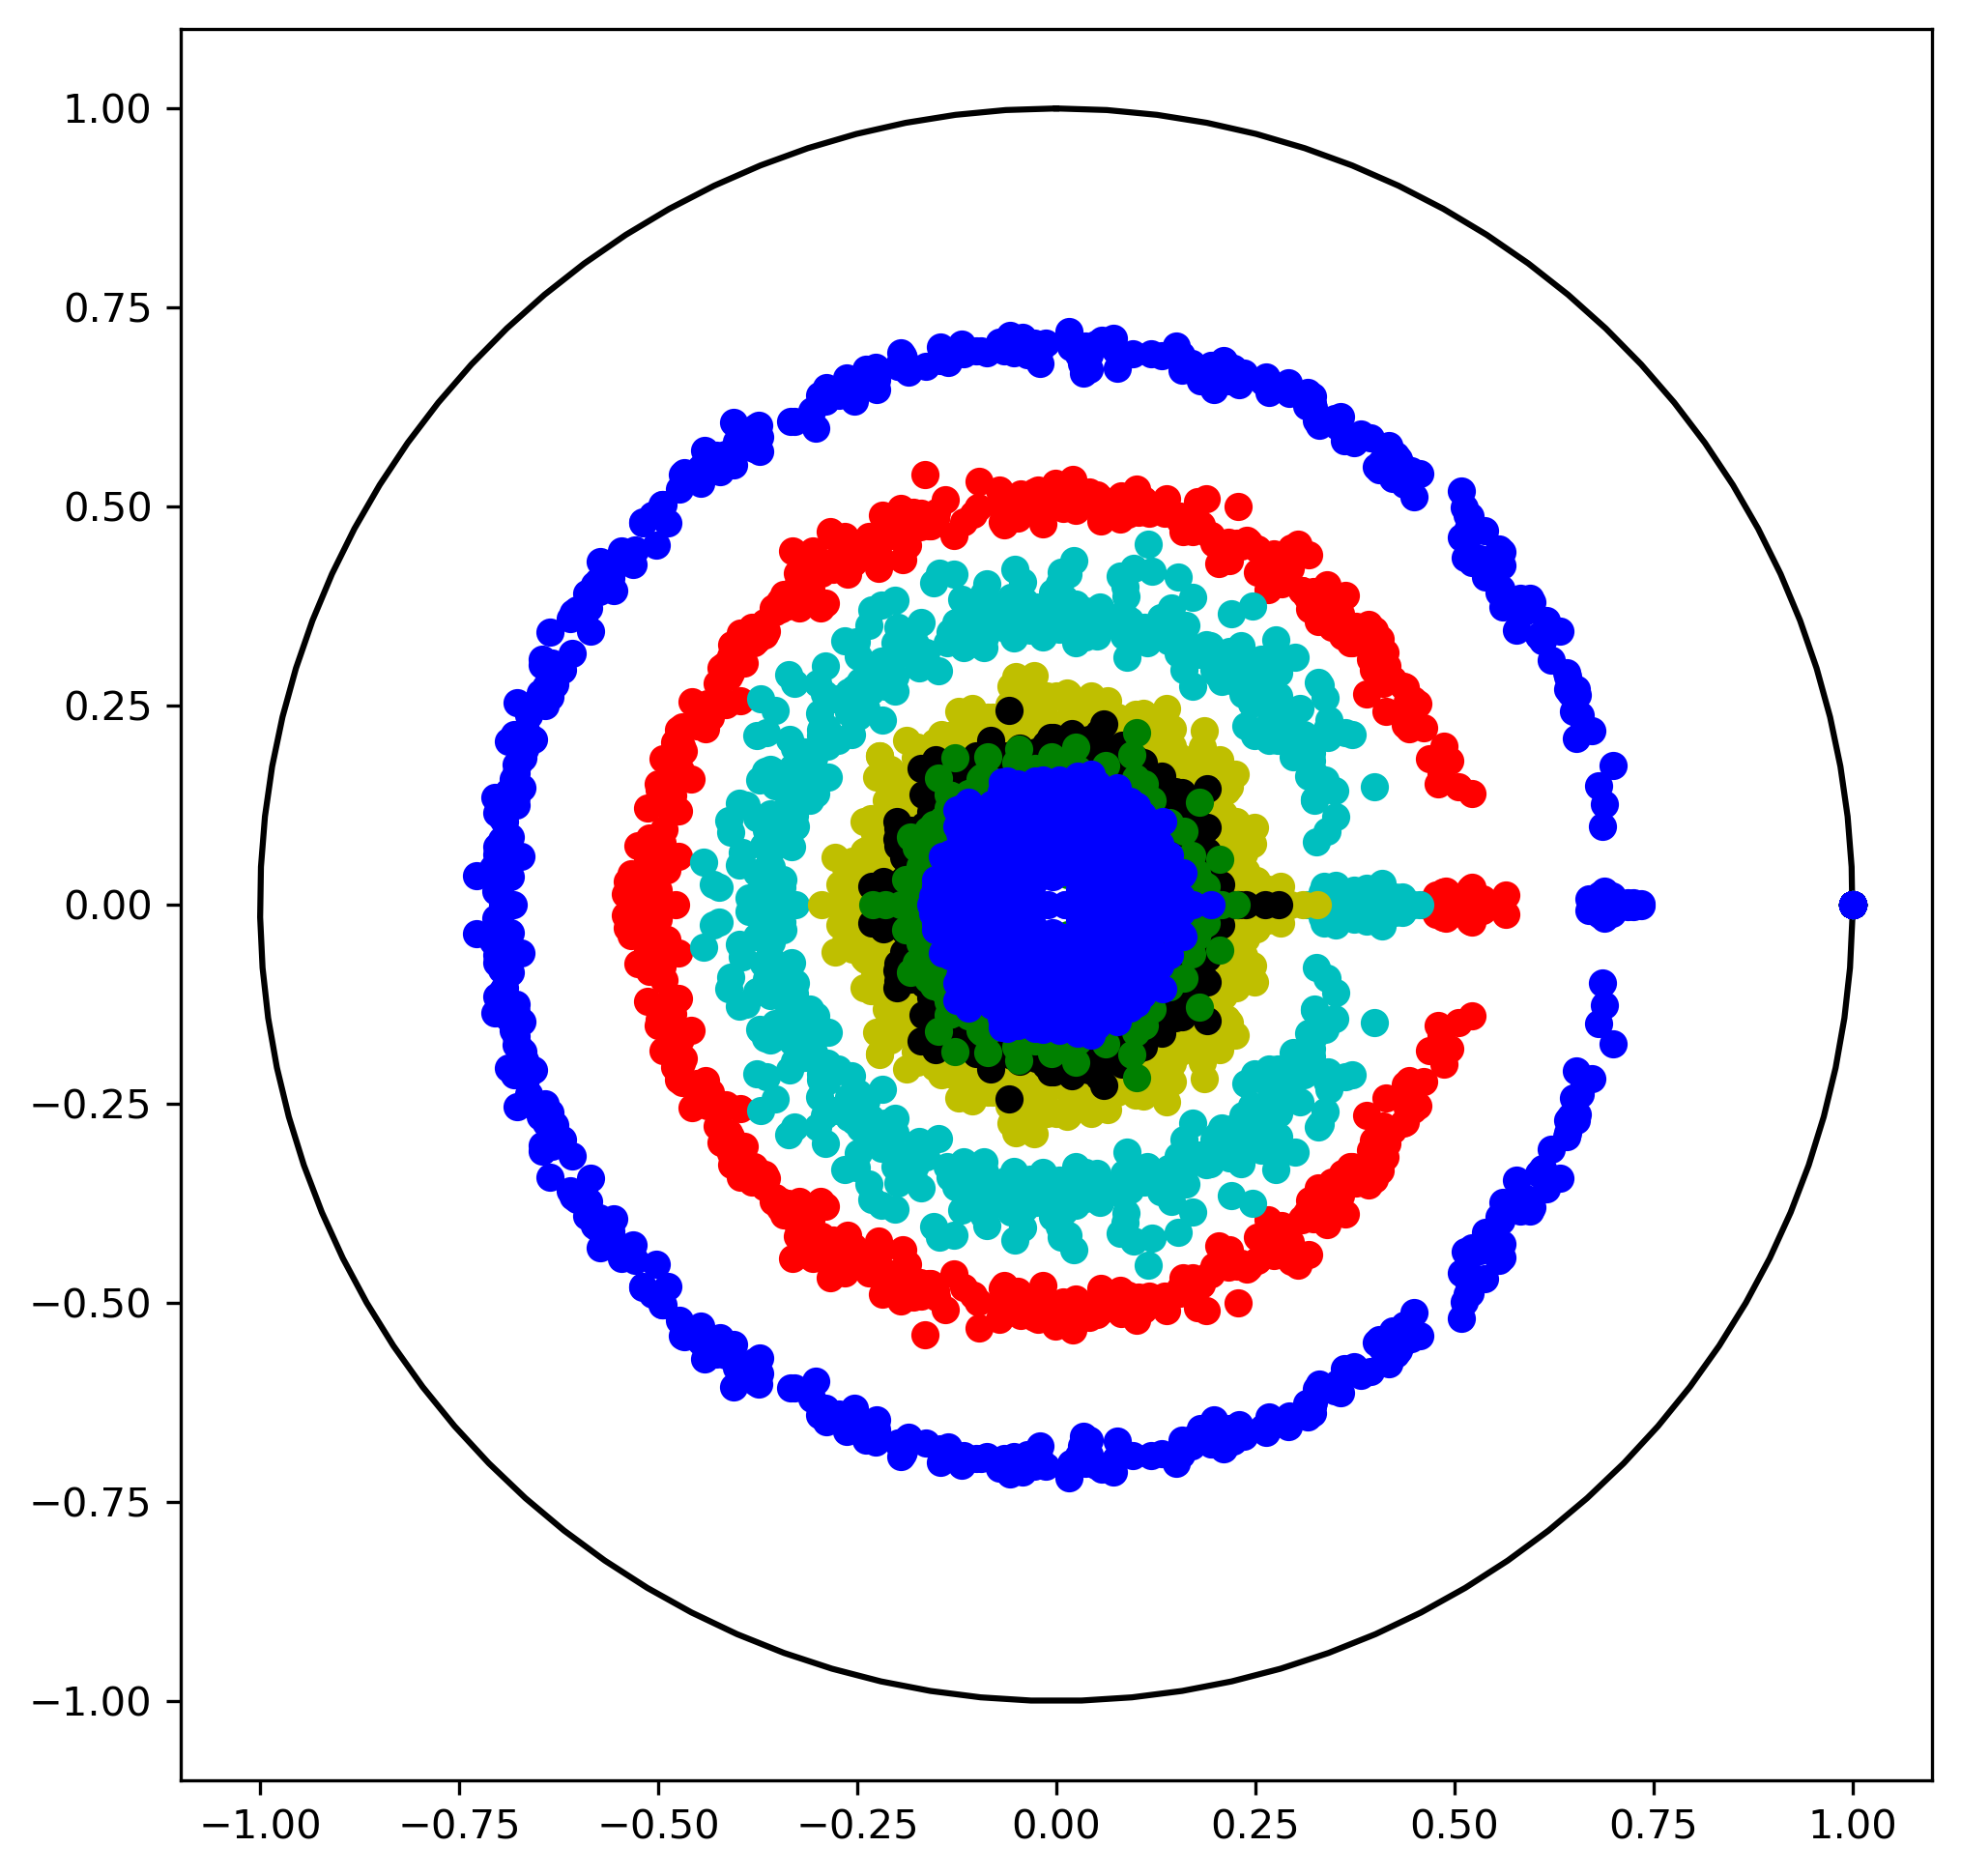

In [19]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")
    
for spectrum in spectrum_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "co")

for spectrum in spectrum_list4:
    plt.plot(spectrum[:,0], spectrum[:,1], "yo")
    
for spectrum in spectrum_list5:
    plt.plot(spectrum[:,0], spectrum[:,1], "ko")
    
for spectrum in spectrum_list6:
    plt.plot(spectrum[:,0], spectrum[:,1], "go")
    
for spectrum in spectrum_list7:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")


plt.show()

In [21]:
R_p1, R_m1, R_pStd1, R_mStd1 = find_outer_inner_R([spectrum_list1[i][:-1] for i in range(10)])
R_p2, R_m2, R_pStd2, R_mStd2 = find_outer_inner_R([spectrum_list2[i][:-1] for i in range(10)])
R_p3, R_m3, R_pStd3, R_mStd3 = find_outer_inner_R([spectrum_list3[i][:-1] for i in range(10)])
R_p4, R_m4, R_pStd4, R_mStd4 = find_outer_inner_R([spectrum_list4[i][:-1] for i in range(10)])
R_p5, R_m5, R_pStd5, R_mStd5 = find_outer_inner_R([spectrum_list5[i][:-1] for i in range(10)])
R_p6, R_m6, R_pStd6, R_mStd6 = find_outer_inner_R([spectrum_list6[i][:-1] for i in range(10)])
R_p7, R_m7, R_pStd7, R_mStd7 = find_outer_inner_R([spectrum_list7[i][:-1] for i in range(10)])

In [24]:
x = [8, 16, 24, 32, 40, 48, 56]
R_plus = np.array([R_p1, R_p2, R_p3, R_p4, R_p5, R_p6, R_p7])
R_minus = np.array([R_m1, R_m2, R_m3, R_m4, R_m5, R_m6, R_m7])
R_plus_std = np.array([R_pStd1, R_pStd2, R_pStd3, R_pStd4, R_pStd5, R_pStd6, R_pStd7])
R_minus_std = np.array([R_mStd1, R_mStd2, R_mStd3, R_mStd4, R_mStd5, R_mStd6, R_mStd7])

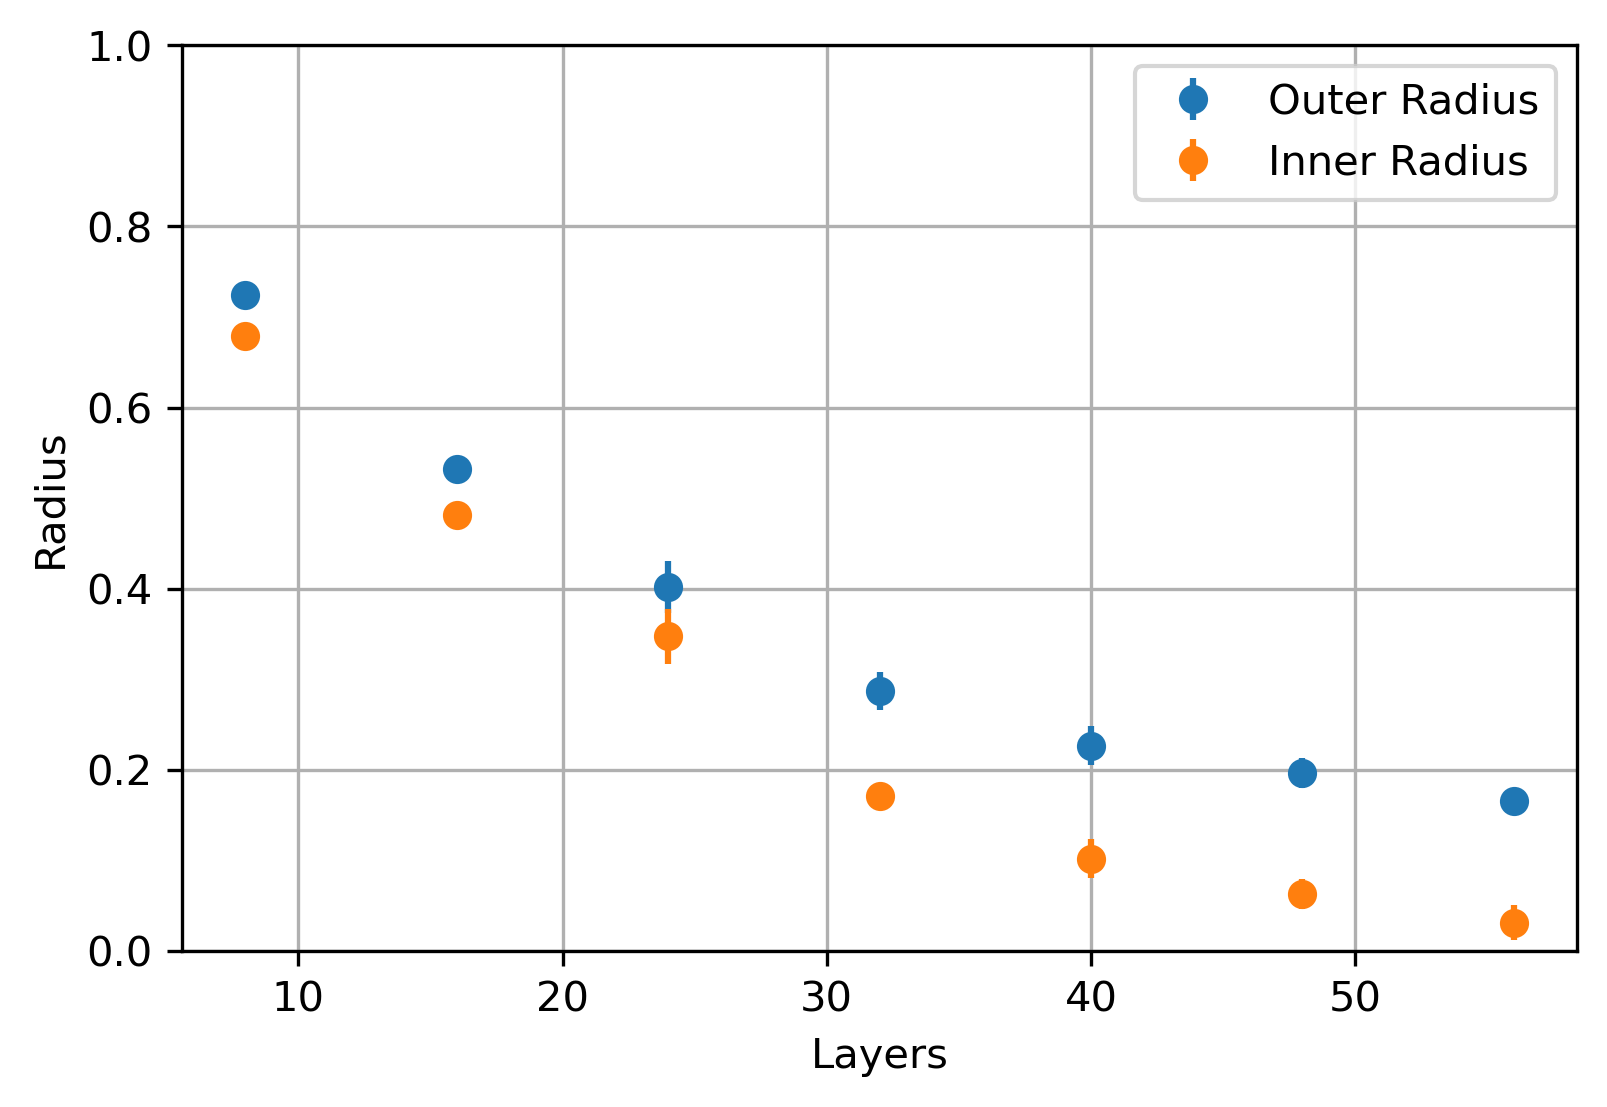

In [28]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, R_plus, yerr=R_plus_std, fmt="o")
plt.errorbar(x, R_minus, yerr=R_minus_std, fmt="o")
#plt.plot(x, R_plus-R_minus, "o")
plt.ylim([0,1])
plt.grid()
plt.xlabel("Layers")
plt.ylabel("Radius")
plt.legend(["Outer Radius", "Inner Radius", "Differance"])
plt.show()

In [31]:
n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
kraus_target_list1 = []

for i in range(10):
    U = Operator(pqc_basic(n, 8).reverse_bits()).data
    kraus_target = DilutedKrausMap(U=U, c=0.7, d=d, rank=4)
    kraus_target_list1.append(kraus_target)

spectrum_target_list1 = [channel_spectrum(channel) for channel in kraus_target_list1]


np.random.seed(42)
random.seed(42)
kraus_target_list2 = []

for i in range(10):
    U = Operator(pqc_basic(n, 16).reverse_bits()).data
    kraus_target = DilutedKrausMap(U=U, c=0.5, d=d, rank=10)
    kraus_target_list2.append(kraus_target)

spectrum_target_list2 = [channel_spectrum(channel) for channel in kraus_target_list2]

np.random.seed(42)
random.seed(42)
kraus_target_list3 = []

for i in range(10):
    U = Operator(pqc_basic(n, 24).reverse_bits()).data
    kraus_target = DilutedKrausMap(U=U, c=0.35, d=d, rank=16)
    kraus_target_list3.append(kraus_target)

spectrum_target_list3 = [channel_spectrum(channel) for channel in kraus_target_list3]

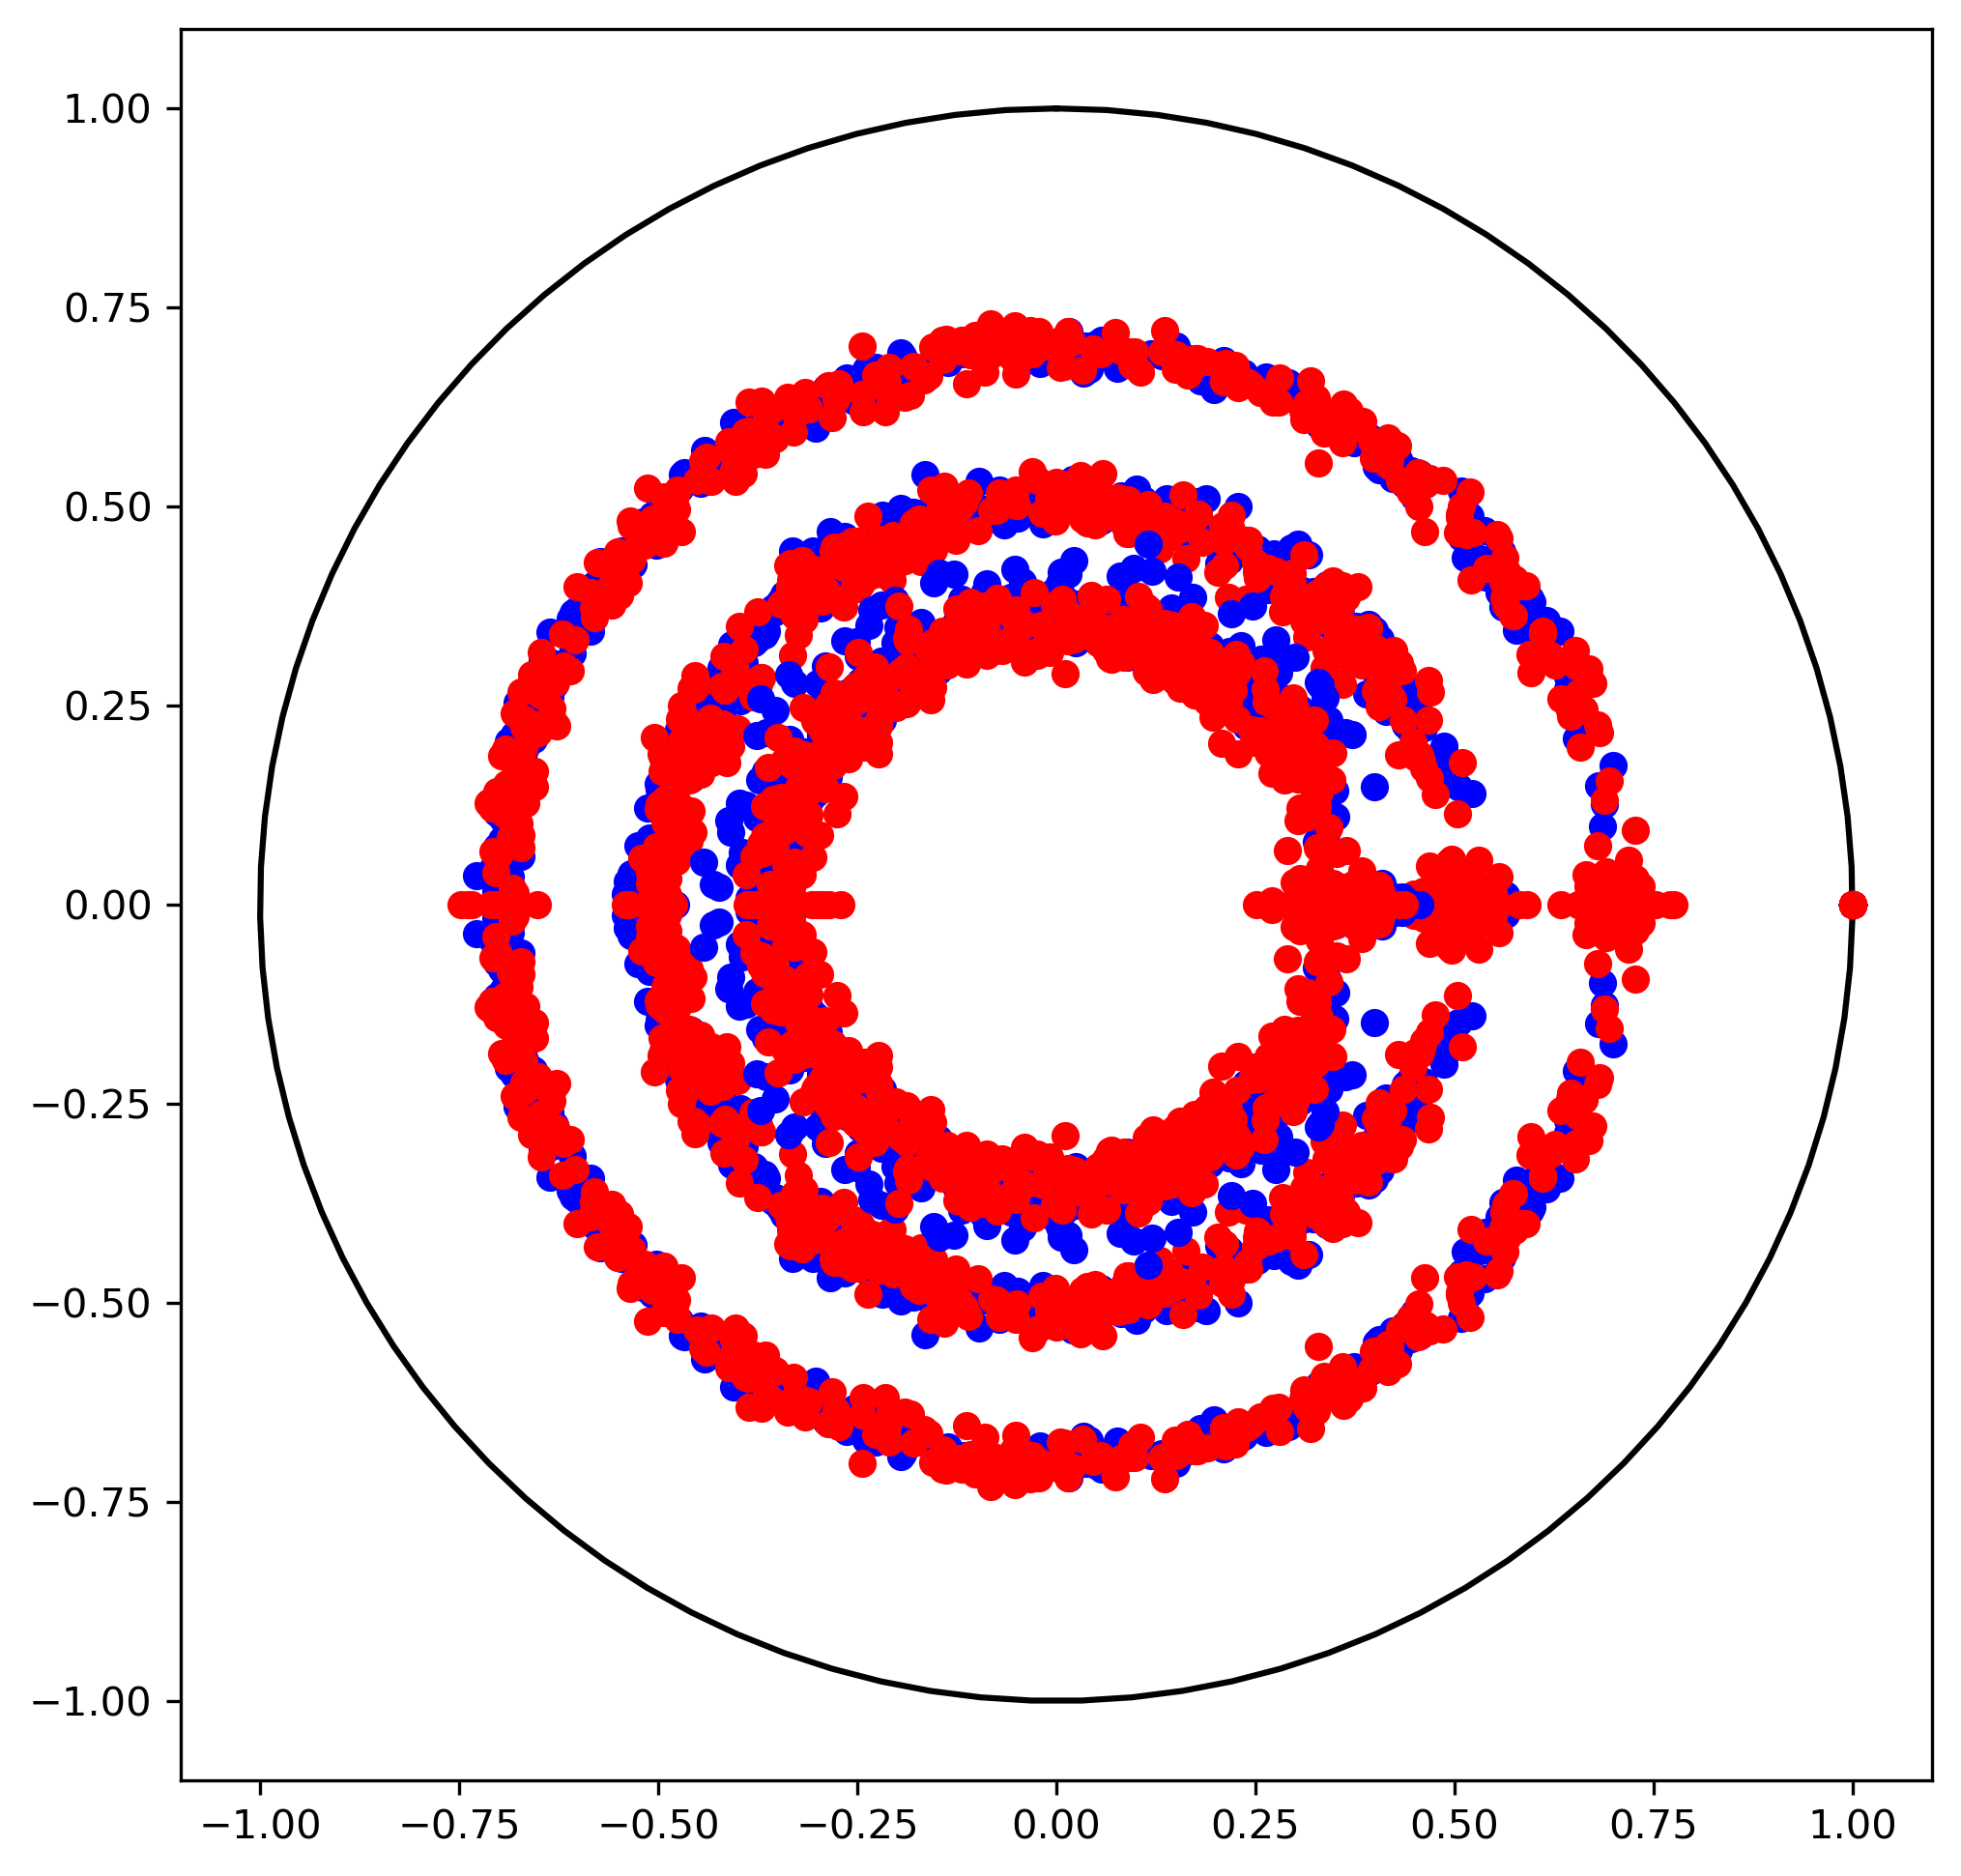

In [32]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_target_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")
    
for spectrum in spectrum_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_target_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")
    
for spectrum in spectrum_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_target_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")


plt.show()

### Angular Distribution

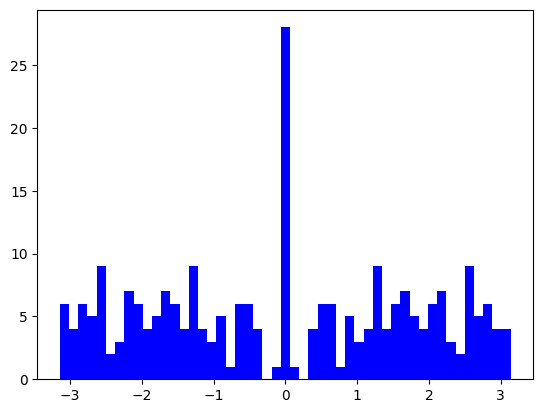

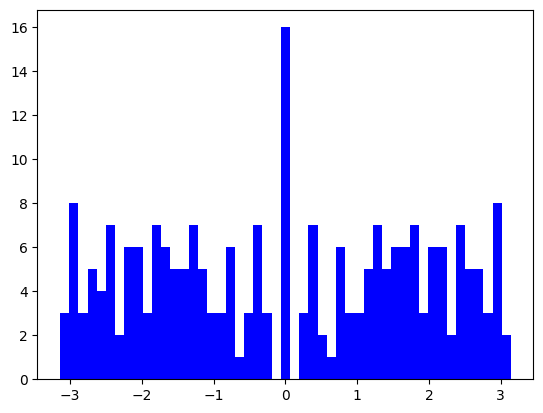

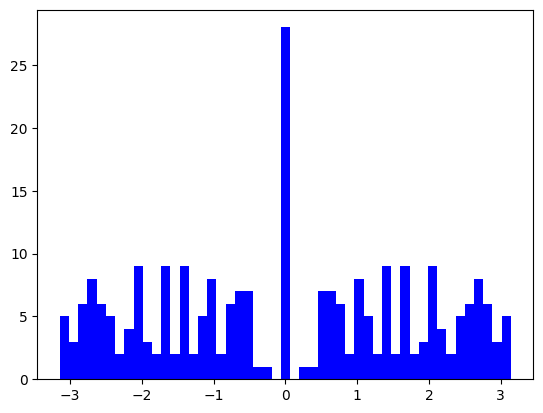

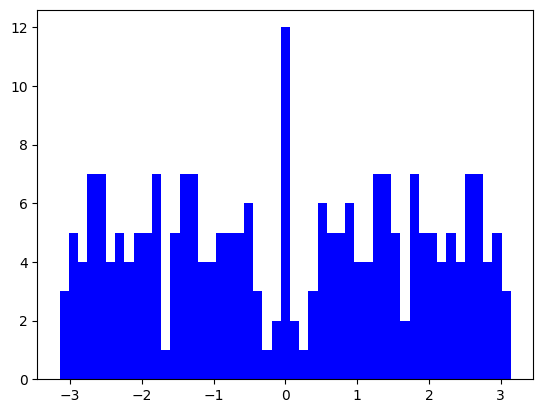

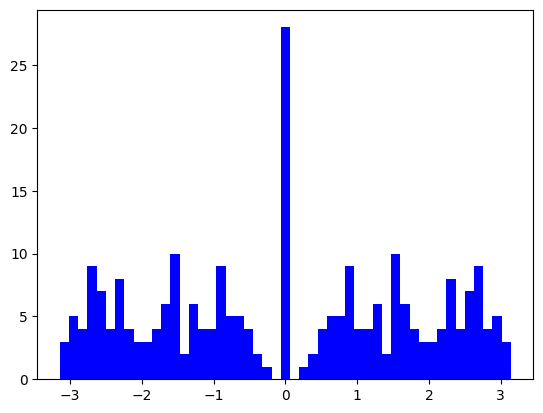

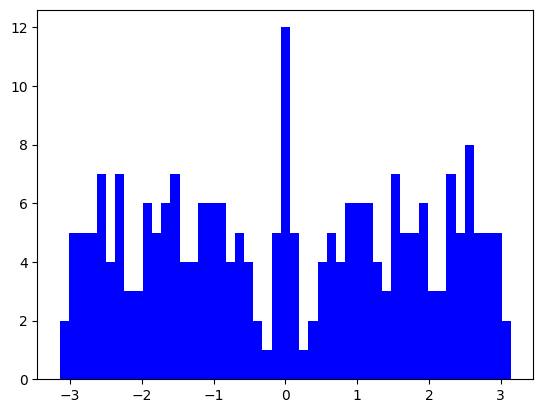

In [33]:
#fig = plt.figure(figsize=(3,3), dpi = 300, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(111)
angular_histogram(spectrum_list1, bins=np.linspace(-np.pi, np.pi))
plt.show()
angular_histogram(spectrum_target_list1, bins=np.linspace(-np.pi, np.pi))
plt.show()

angular_histogram(spectrum_list2, bins=np.linspace(-np.pi, np.pi))
plt.show()
angular_histogram(spectrum_target_list2, bins=np.linspace(-np.pi, np.pi))
plt.show()

angular_histogram(spectrum_list3, bins=np.linspace(-np.pi, np.pi))
plt.show()
angular_histogram(spectrum_target_list3, bins=np.linspace(-np.pi, np.pi))
plt.show()

## Purity of Steady State

In [43]:
belem_purity_list1 = [state_purity(channel_steady_state(channel)) for channel in channel_list1]
kraus_purity_list1 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list1]

belem_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in channel_list2]
kraus_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list2]

belem_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in channel_list2]
kraus_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list2]

belem_purity_list7 = [state_purity(channel_steady_state(channel)) for channel in channel_list7]
#kraus_purity_list7 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list7]

In [37]:
print(np.abs(np.array(belem_purity_list1)))
print(np.abs(np.array(kraus_purity_list1)))
print("-----")
print(np.abs(np.array(belem_purity_list2)))
print(np.abs(np.array(kraus_purity_list2)))

[0.1259 0.1262 0.1269 0.1255]
[0.1307 0.1314 0.1296 0.1291]
-----
[0.1259 0.126  0.1262 0.1261]
[0.1288 0.1288 0.1281 0.1284]


### Effective Rank

In [50]:
belem_effRank_list1 = [effective_rank(channel) for channel in channel_list1]
kraus_effRank_list1 = [effective_rank(channel) for channel in kraus_target_list1]

belem_effRank_list2 = [effective_rank(channel) for channel in channel_list2]
kraus_effRank_list2 = [effective_rank(channel) for channel in kraus_target_list2]

belem_effRank_list3 = [effective_rank(channel) for channel in channel_list3]
kraus_effRank_list3 = [effective_rank(channel) for channel in kraus_target_list3]

belem_effRank_list7 = [effective_rank(channel) for channel in channel_list7]
#kraus_effRank_list3 = [effective_rank(channel) for channel in kraus_target_list3]

In [51]:
print(np.abs(np.array(belem_effRank_list1)))
print(np.abs(np.array(kraus_effRank_list1)))
print("-----")

print(np.abs(np.array(belem_effRank_list2)))
print(np.abs(np.array(kraus_effRank_list2)))
print("-----")

print(np.abs(np.array(belem_effRank_list3)))
print(np.abs(np.array(kraus_effRank_list3)))
print("-----")
print(np.abs(np.array(belem_effRank_list7)))
#print(np.abs(np.array(kraus_effRank_list3)))
print("-----")


[2.063  1.9669 1.9799 2.0274]
[1.9189 1.9255 1.9384 1.9133]
-----
[3.5756 3.6656 3.9043 3.5228]
[3.4888 3.4872 3.4589 3.4765]
-----
[6.2866 6.2715 5.8807 6.7   ]
[6.1928 6.1562 6.2503 6.1062]
-----
[22.7841 24.5647 25.5723 25.3715]
-----


### Three Qubits, Spectra

C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\3442451697.py:12: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FCB3FF2BC0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","No Delay","5$\mu$","10$\mu$", "15$\mu$","20$\mu$", "25$\mu$"], loc = "upper right")


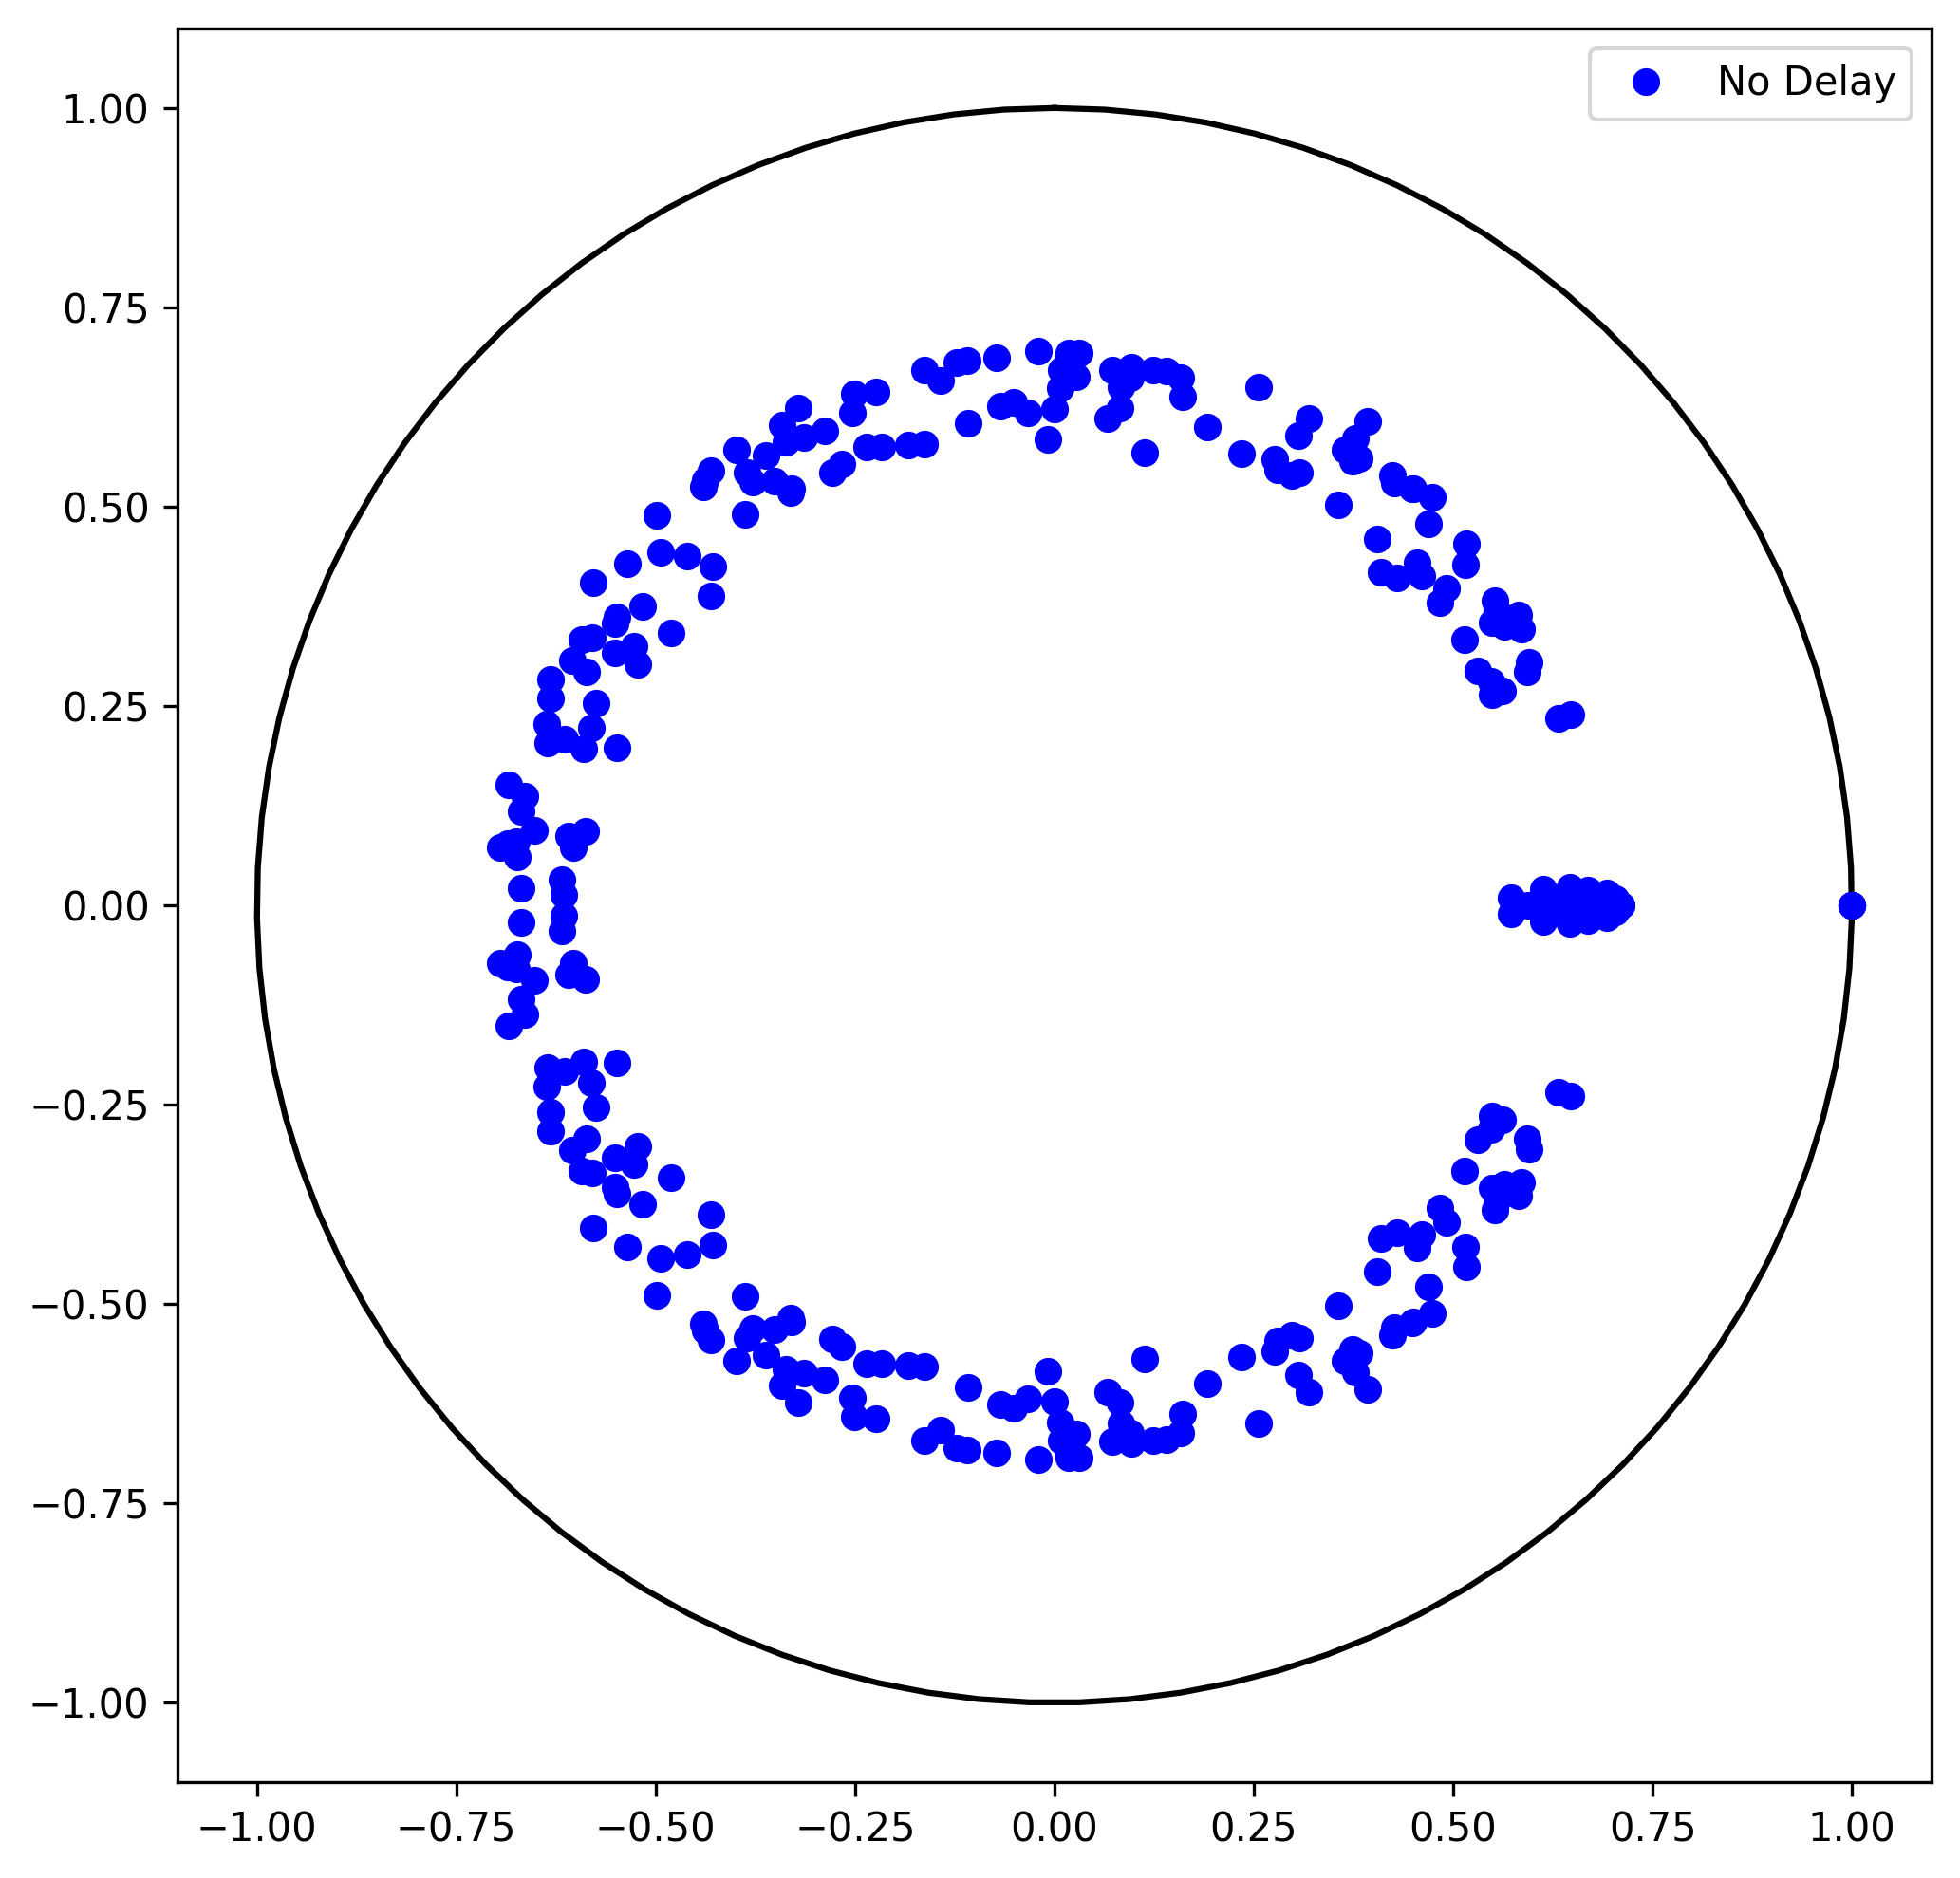

In [30]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

spectrum1 = [np.concatenate([spectrum[:,0] for spectrum in spectrum1_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum1_list])]

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
plt.plot(*spectrum1, "bo")
    
plt.legend(["_","No Delay","5$\mu$","10$\mu$", "15$\mu$","20$\mu$", "25$\mu$"], loc = "upper right")

plt.show()

C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\2241957620.py:13: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FCA4662350> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$ s Delay", "15$\mu$ s Delay","20$\mu$ s Delay", "25$\mu$ s Delay"], loc = "upper right")


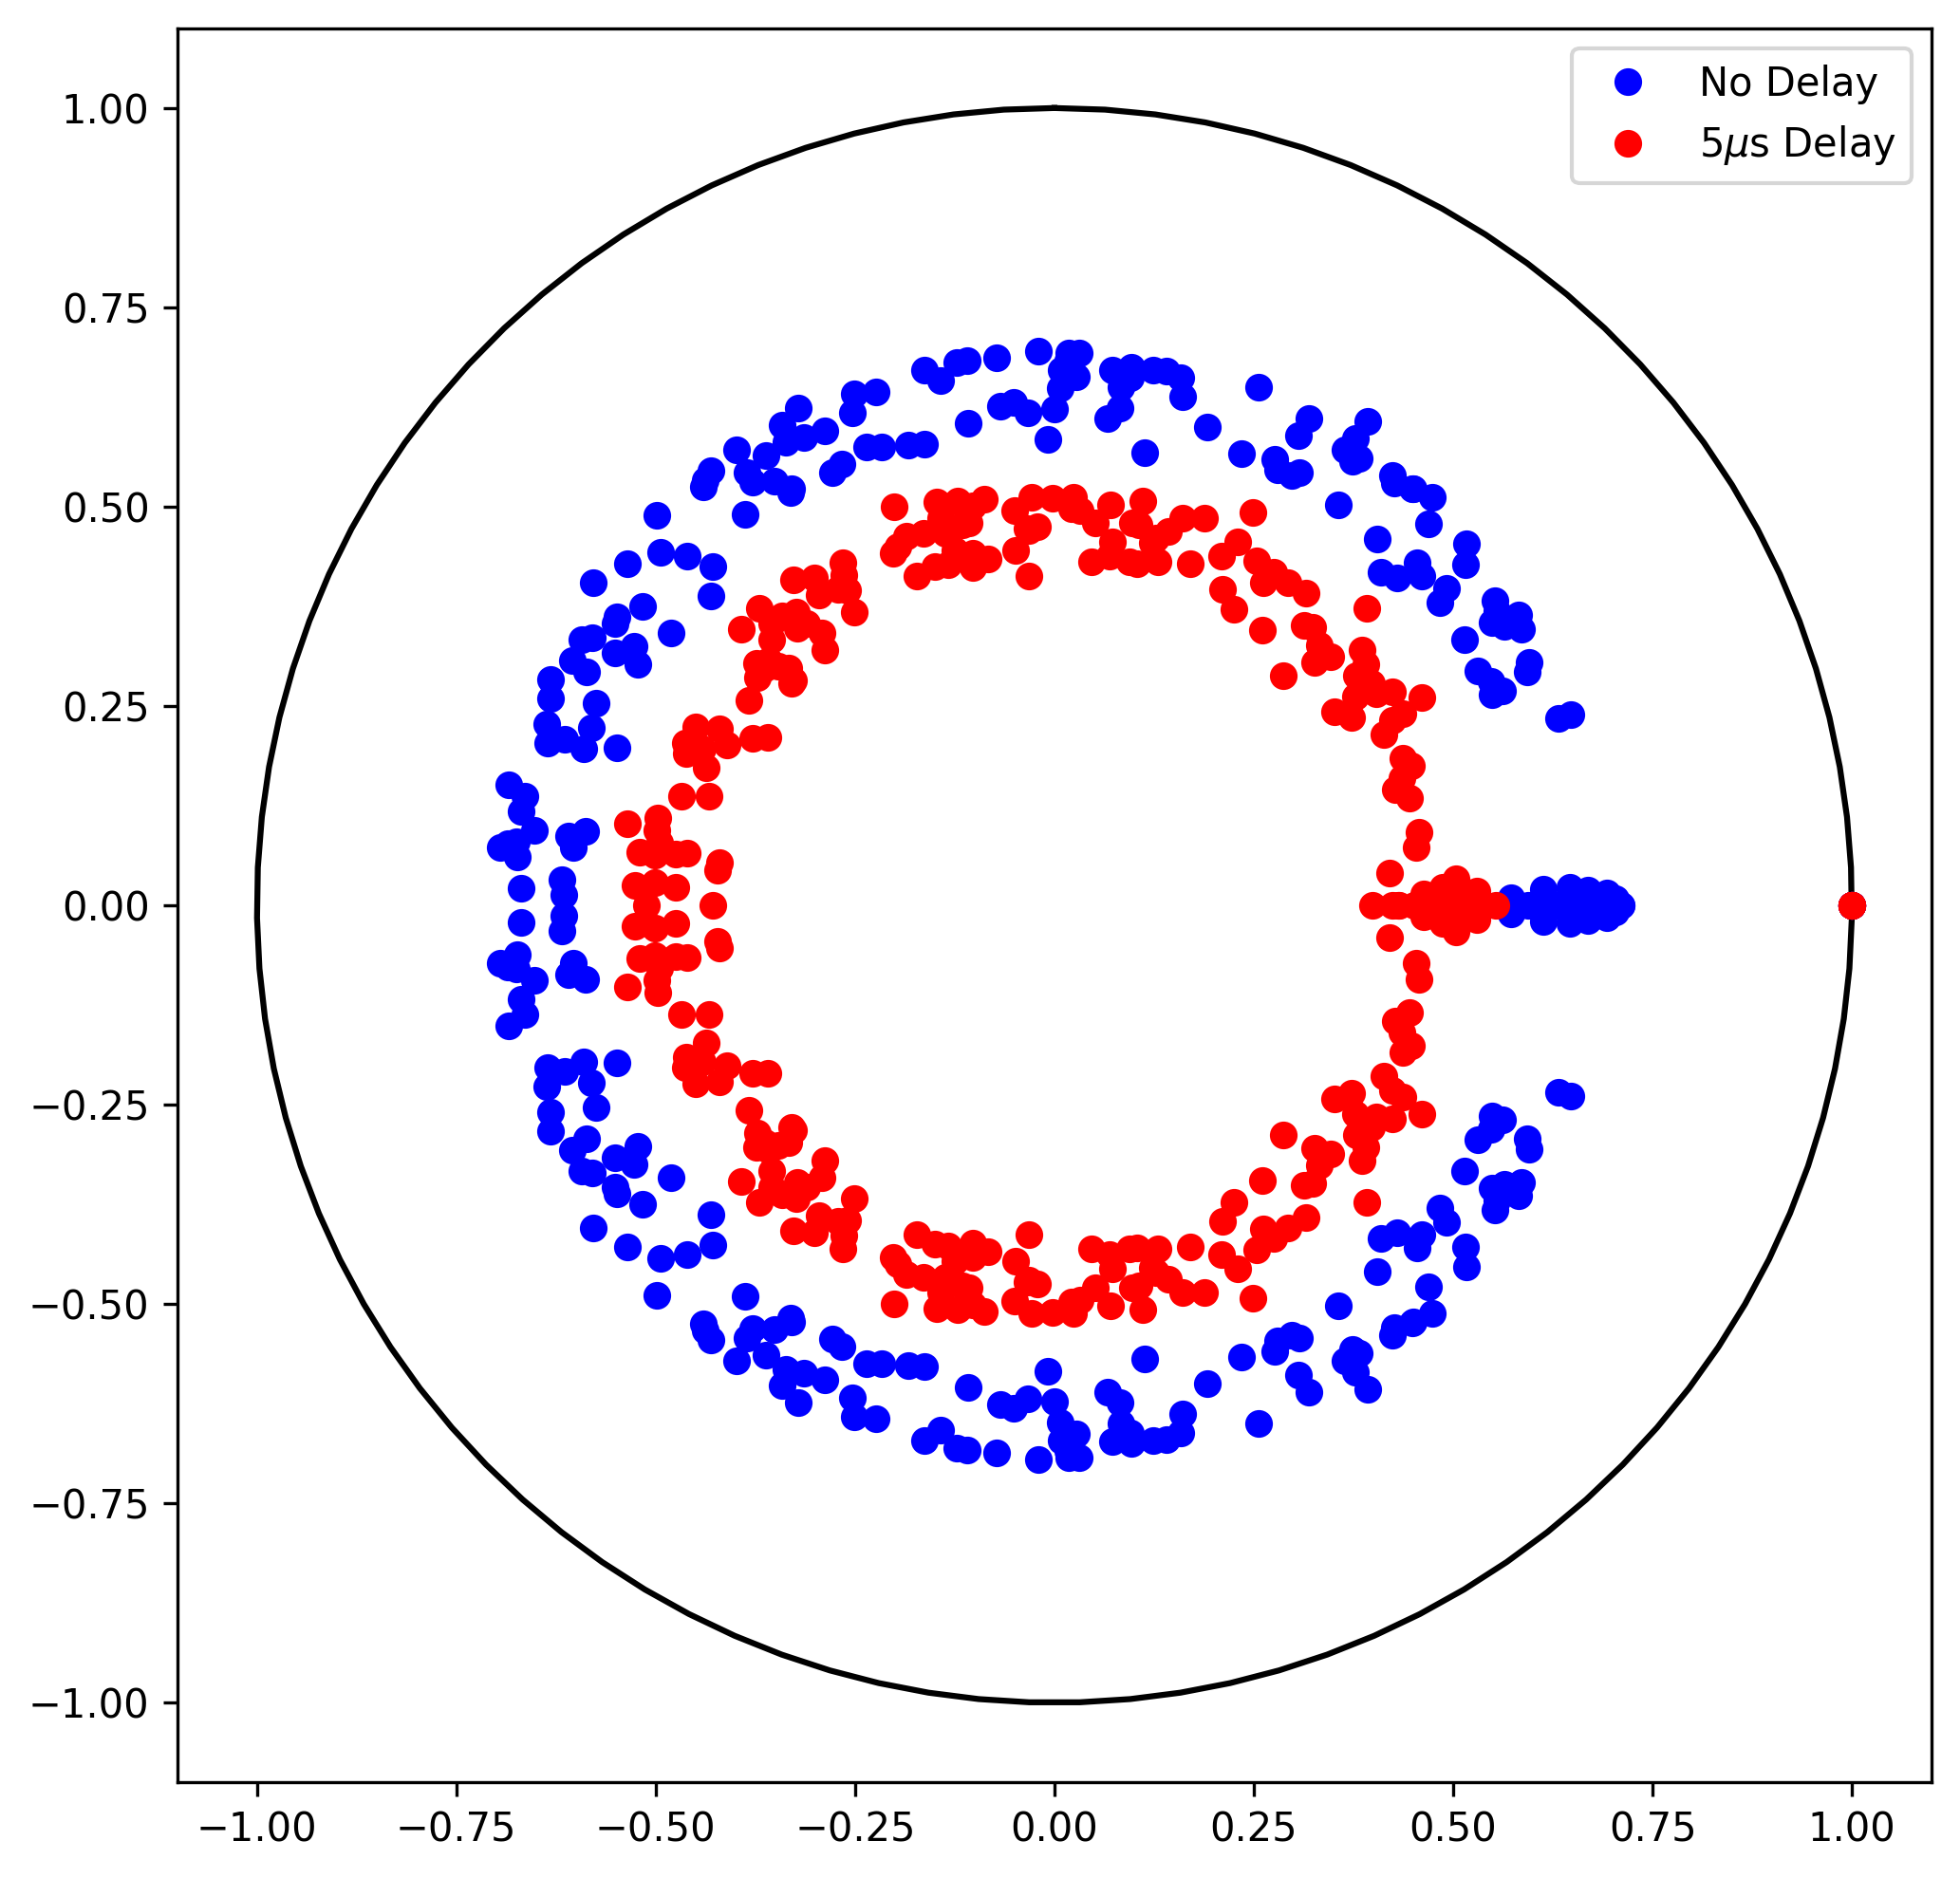

In [128]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

spectrum2 = [np.concatenate([spectrum[:,0] for spectrum in spectrum2_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum2_list])]

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
plt.plot(*spectrum1, "bo")
plt.plot(*spectrum2, "ro")
    
plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$ s Delay", "15$\mu$ s Delay","20$\mu$ s Delay", "25$\mu$ s Delay"], loc = "upper right")

plt.show()

C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\1784452718.py:14: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FC85EF0BE0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")


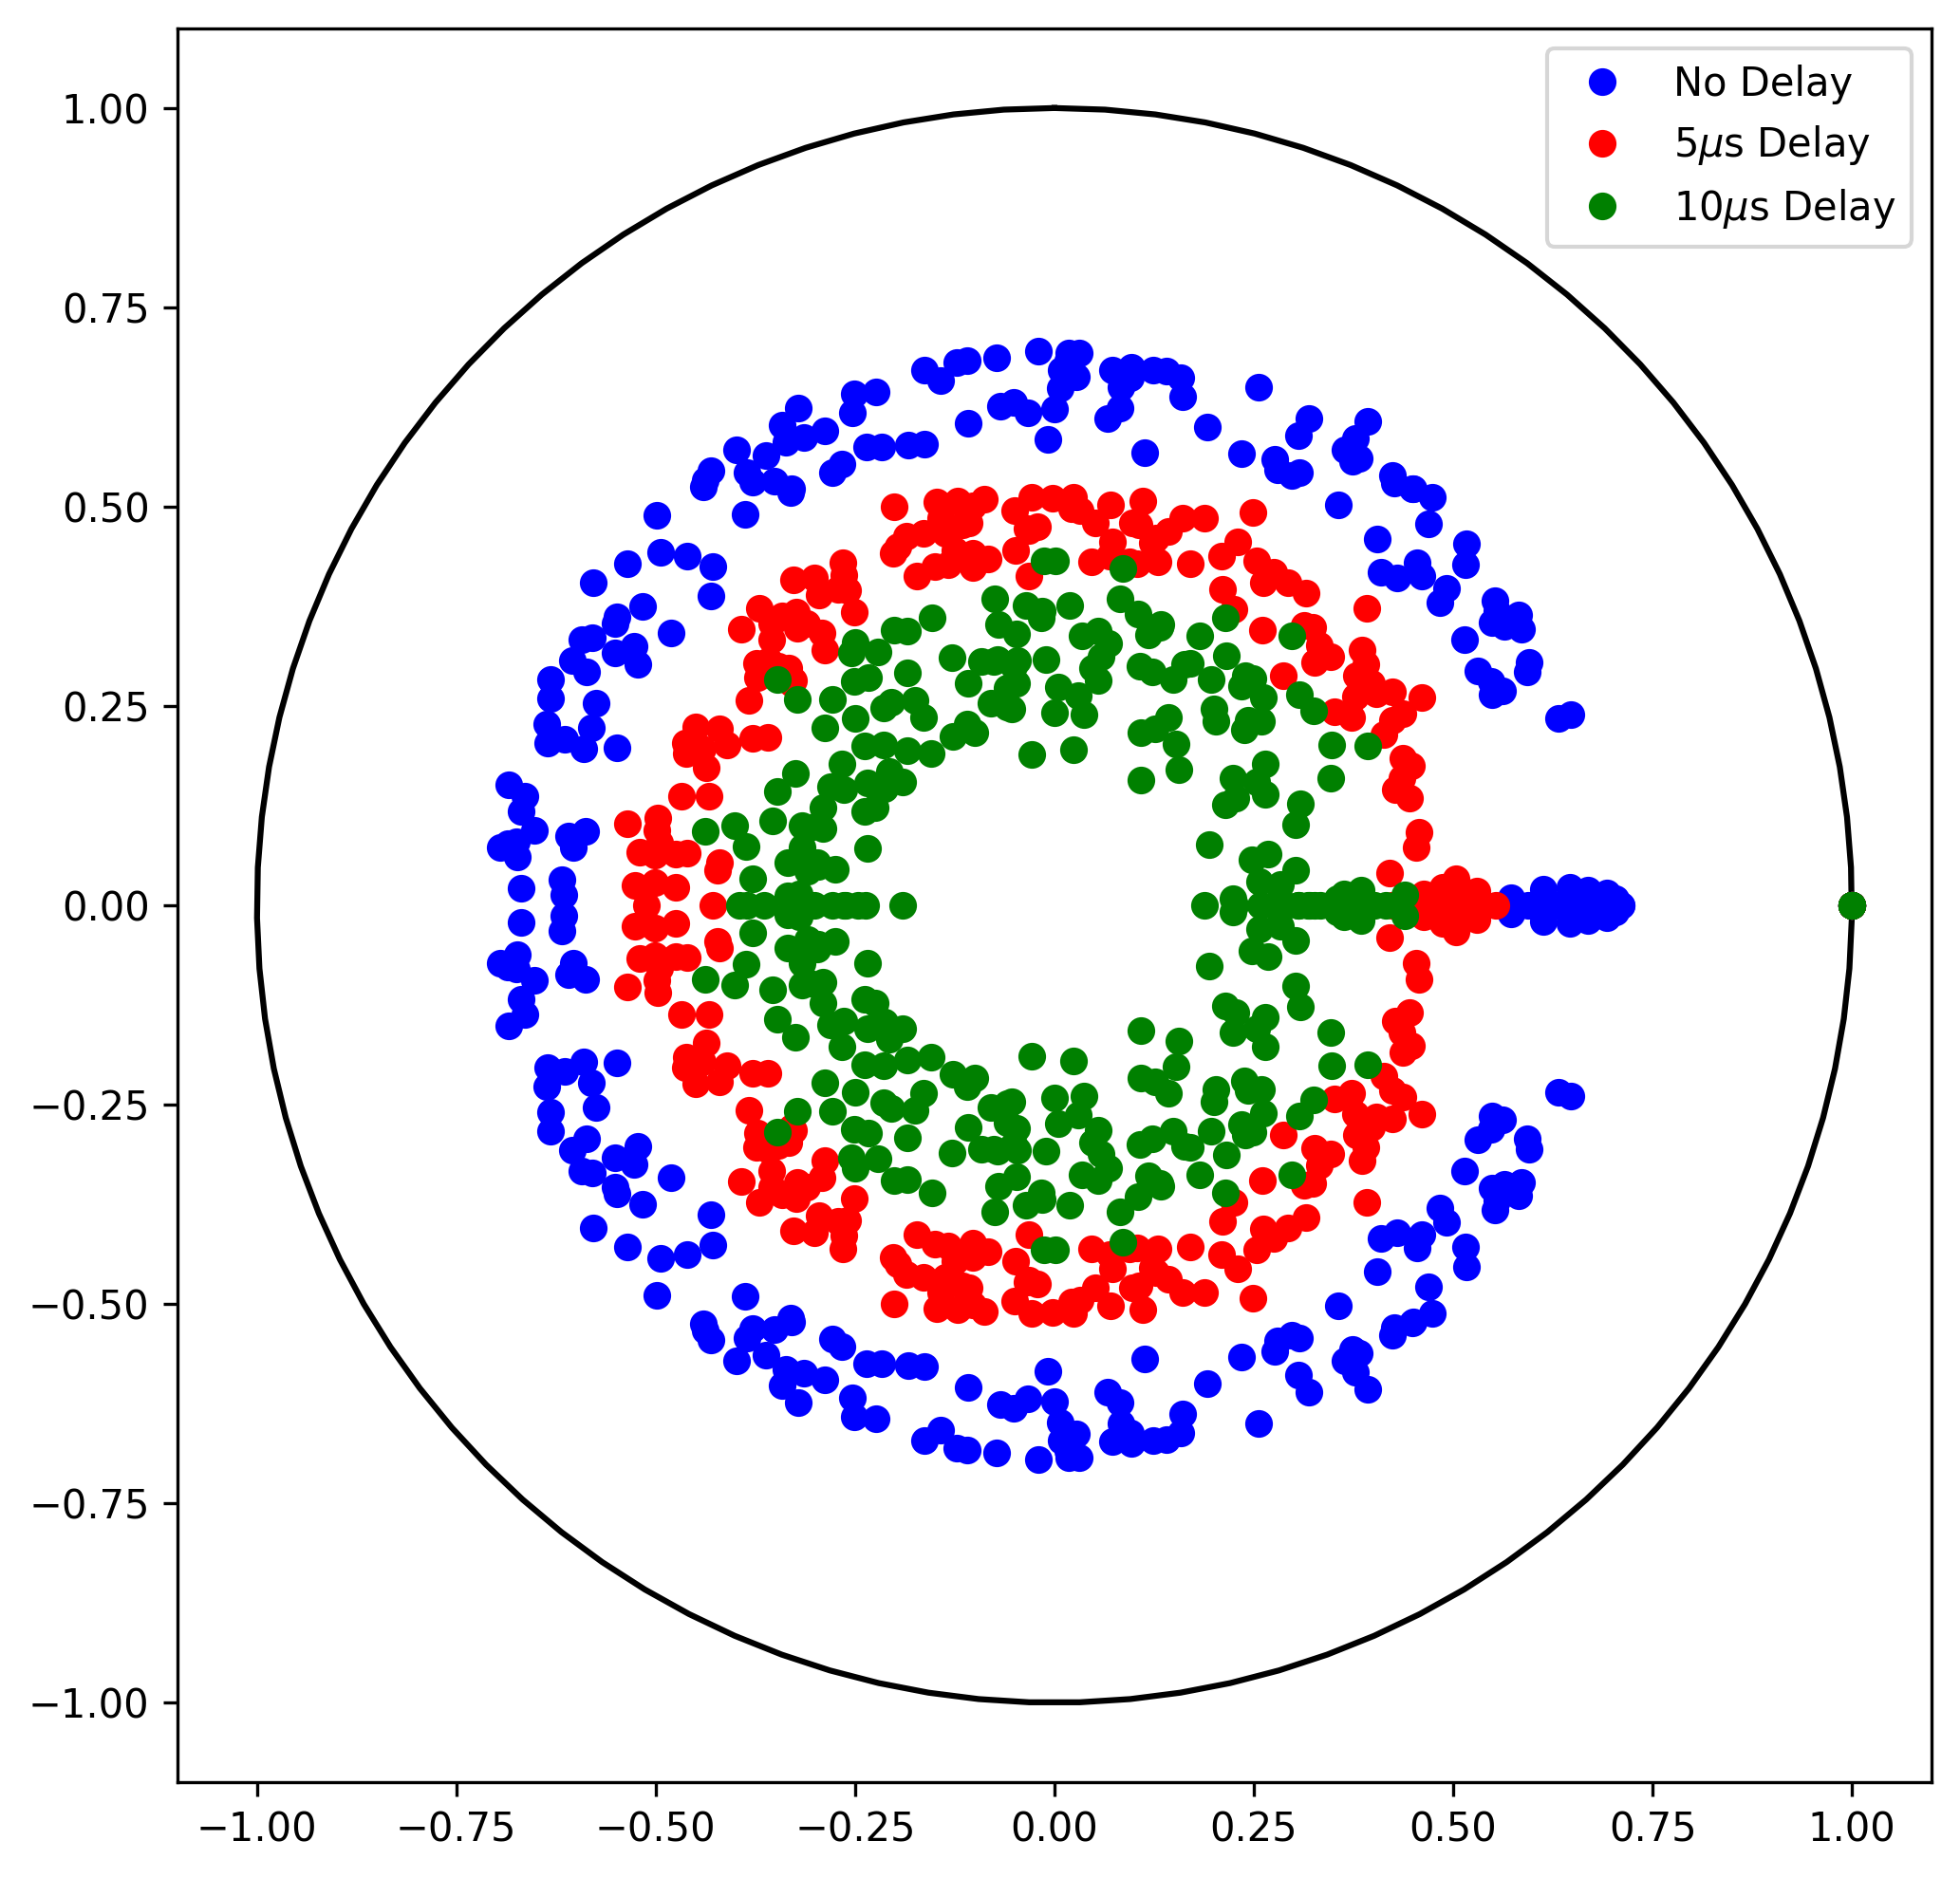

In [129]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

spectrum3 = [np.concatenate([spectrum[:,0] for spectrum in spectrum3_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum3_list])]

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
plt.plot(*spectrum1, "bo")
plt.plot(*spectrum2, "ro")
plt.plot(*spectrum3, "go")
    
plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.show()

C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\2632584600.py:15: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FCA4601150> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")


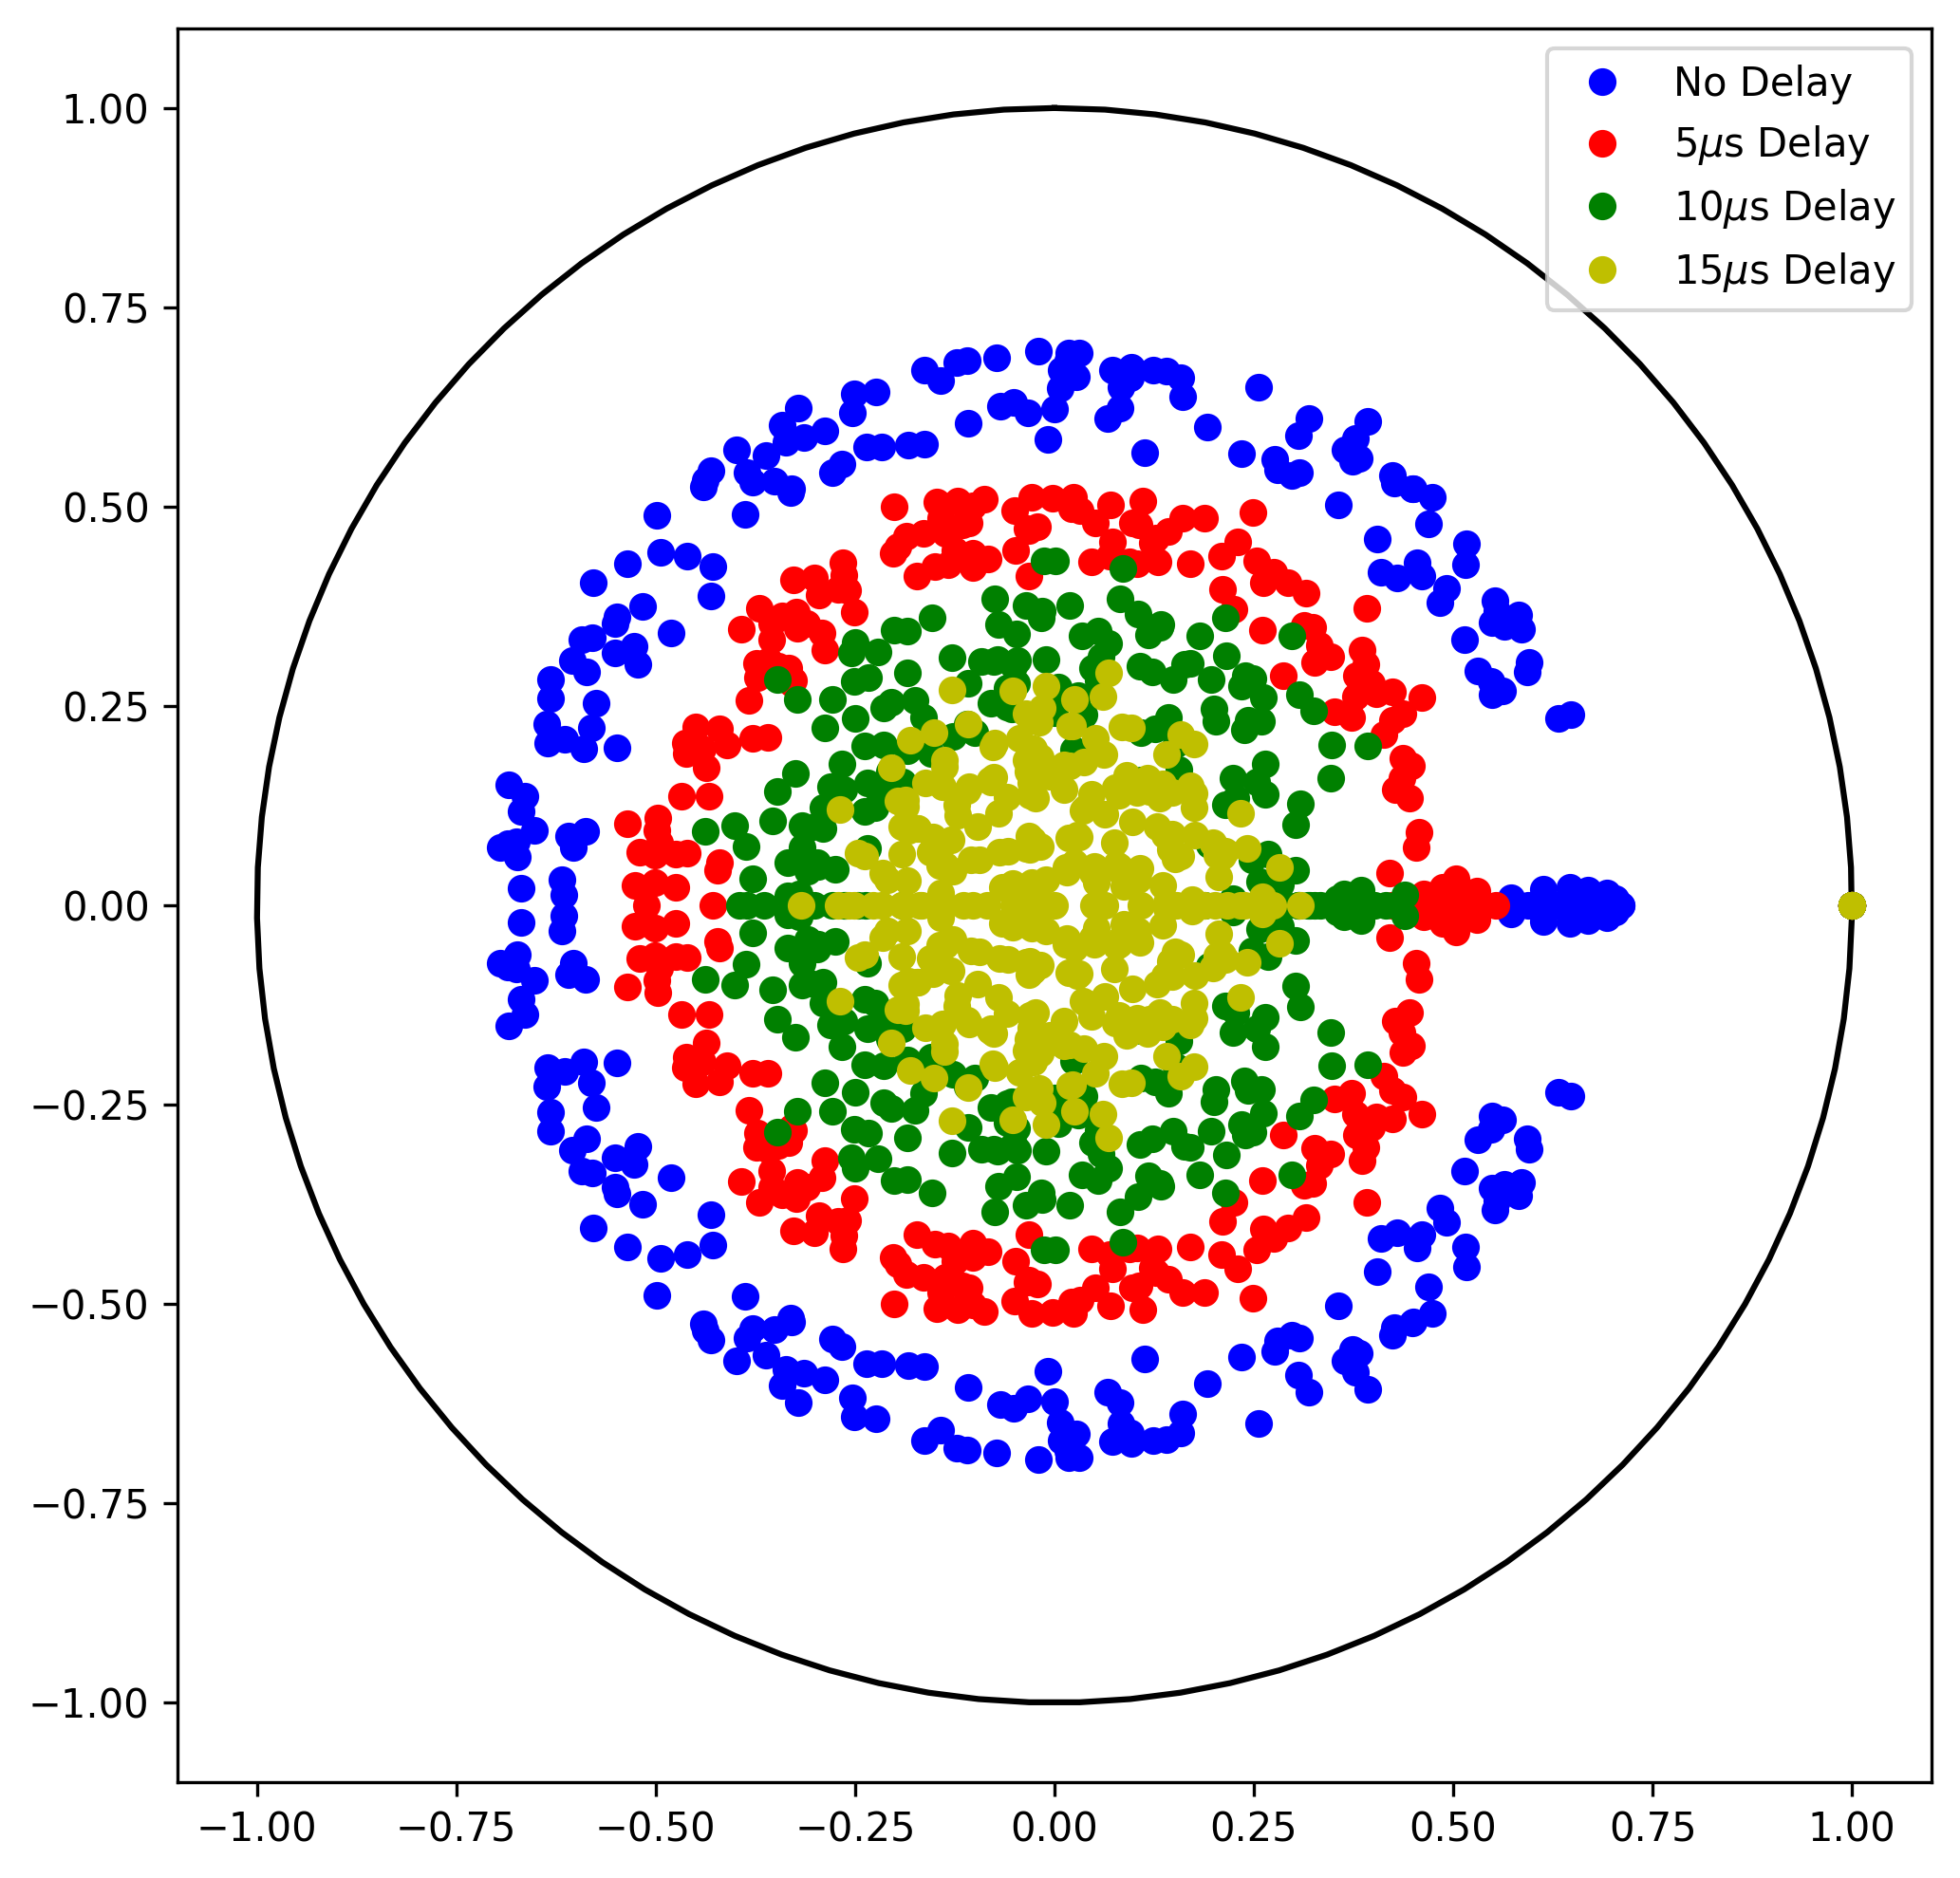

In [130]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

spectrum4 = [np.concatenate([spectrum[:,0] for spectrum in spectrum4_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum4_list])]

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
plt.plot(*spectrum1, "bo")
plt.plot(*spectrum2, "ro")
plt.plot(*spectrum3, "go")
plt.plot(*spectrum4, "yo")
    
plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.show()

C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\117887113.py:16: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FCB40C3130> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")


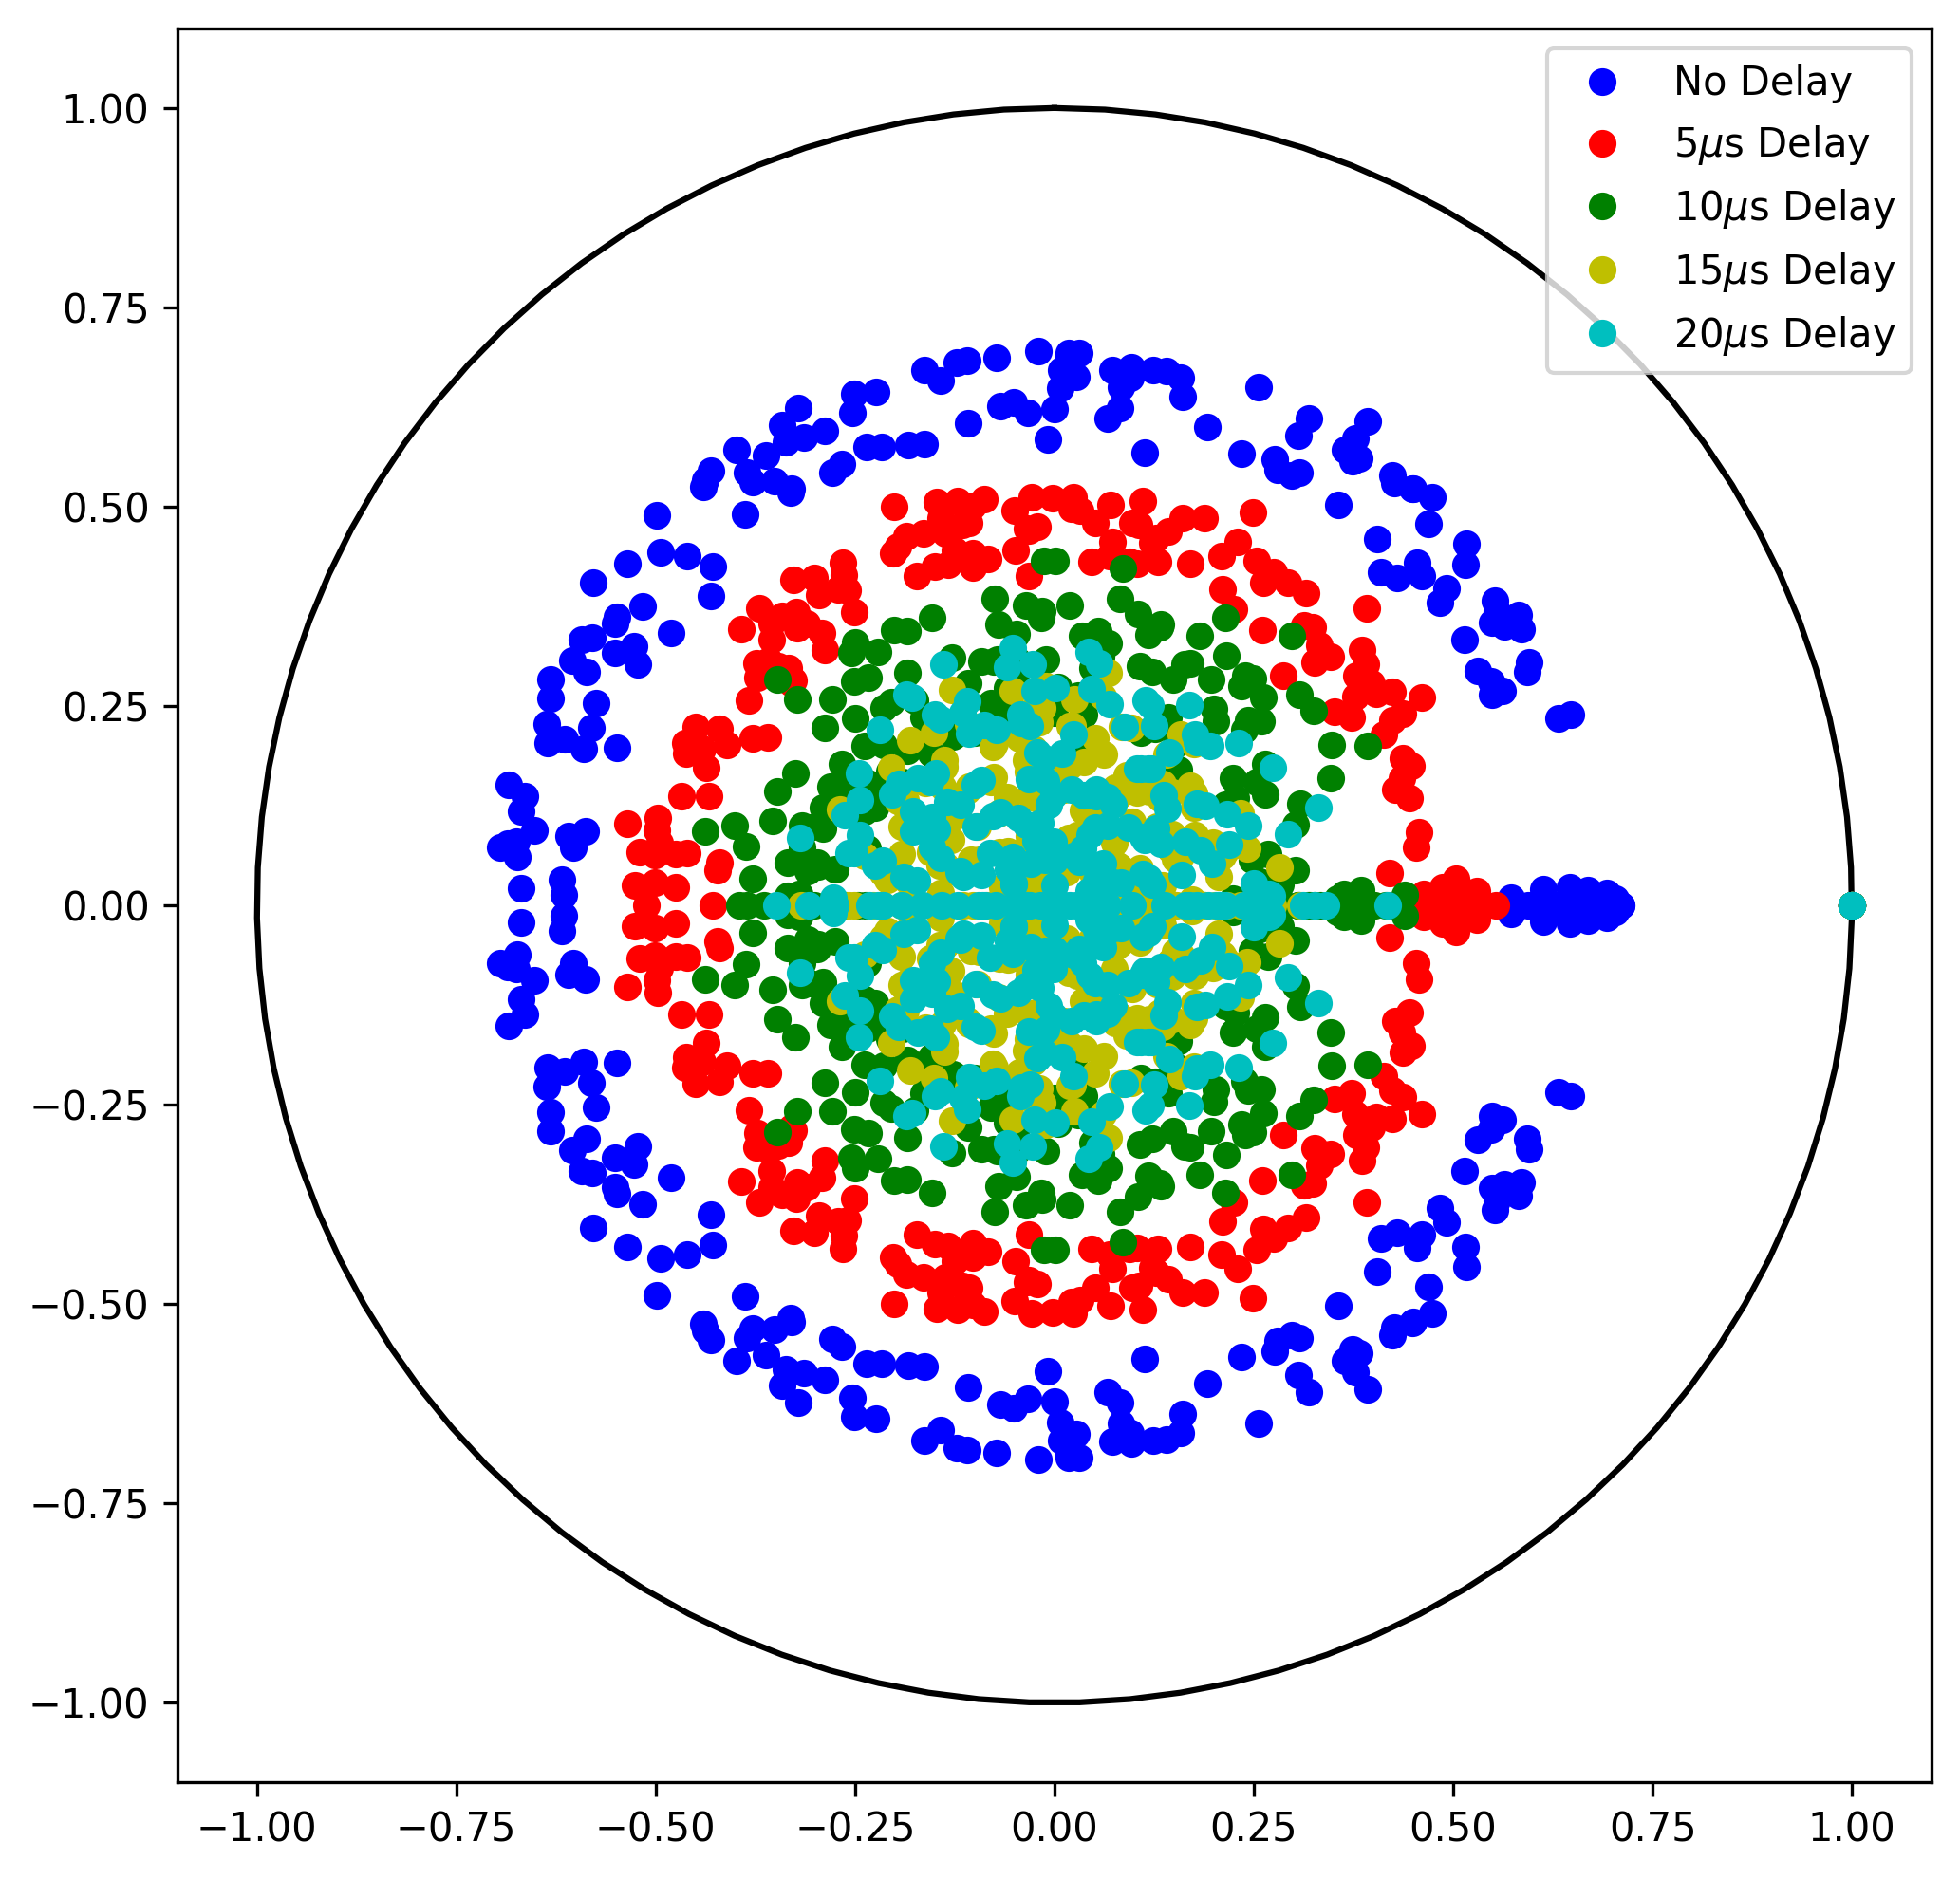

In [131]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

spectrum5 = [np.concatenate([spectrum[:,0] for spectrum in spectrum5_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum5_list])]

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
plt.plot(*spectrum1, "bo")
plt.plot(*spectrum2, "ro")
plt.plot(*spectrum3, "go")
plt.plot(*spectrum4, "yo")
plt.plot(*spectrum5, "co")
    
plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.show()

C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\84990657.py:17: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FC84556B60> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")


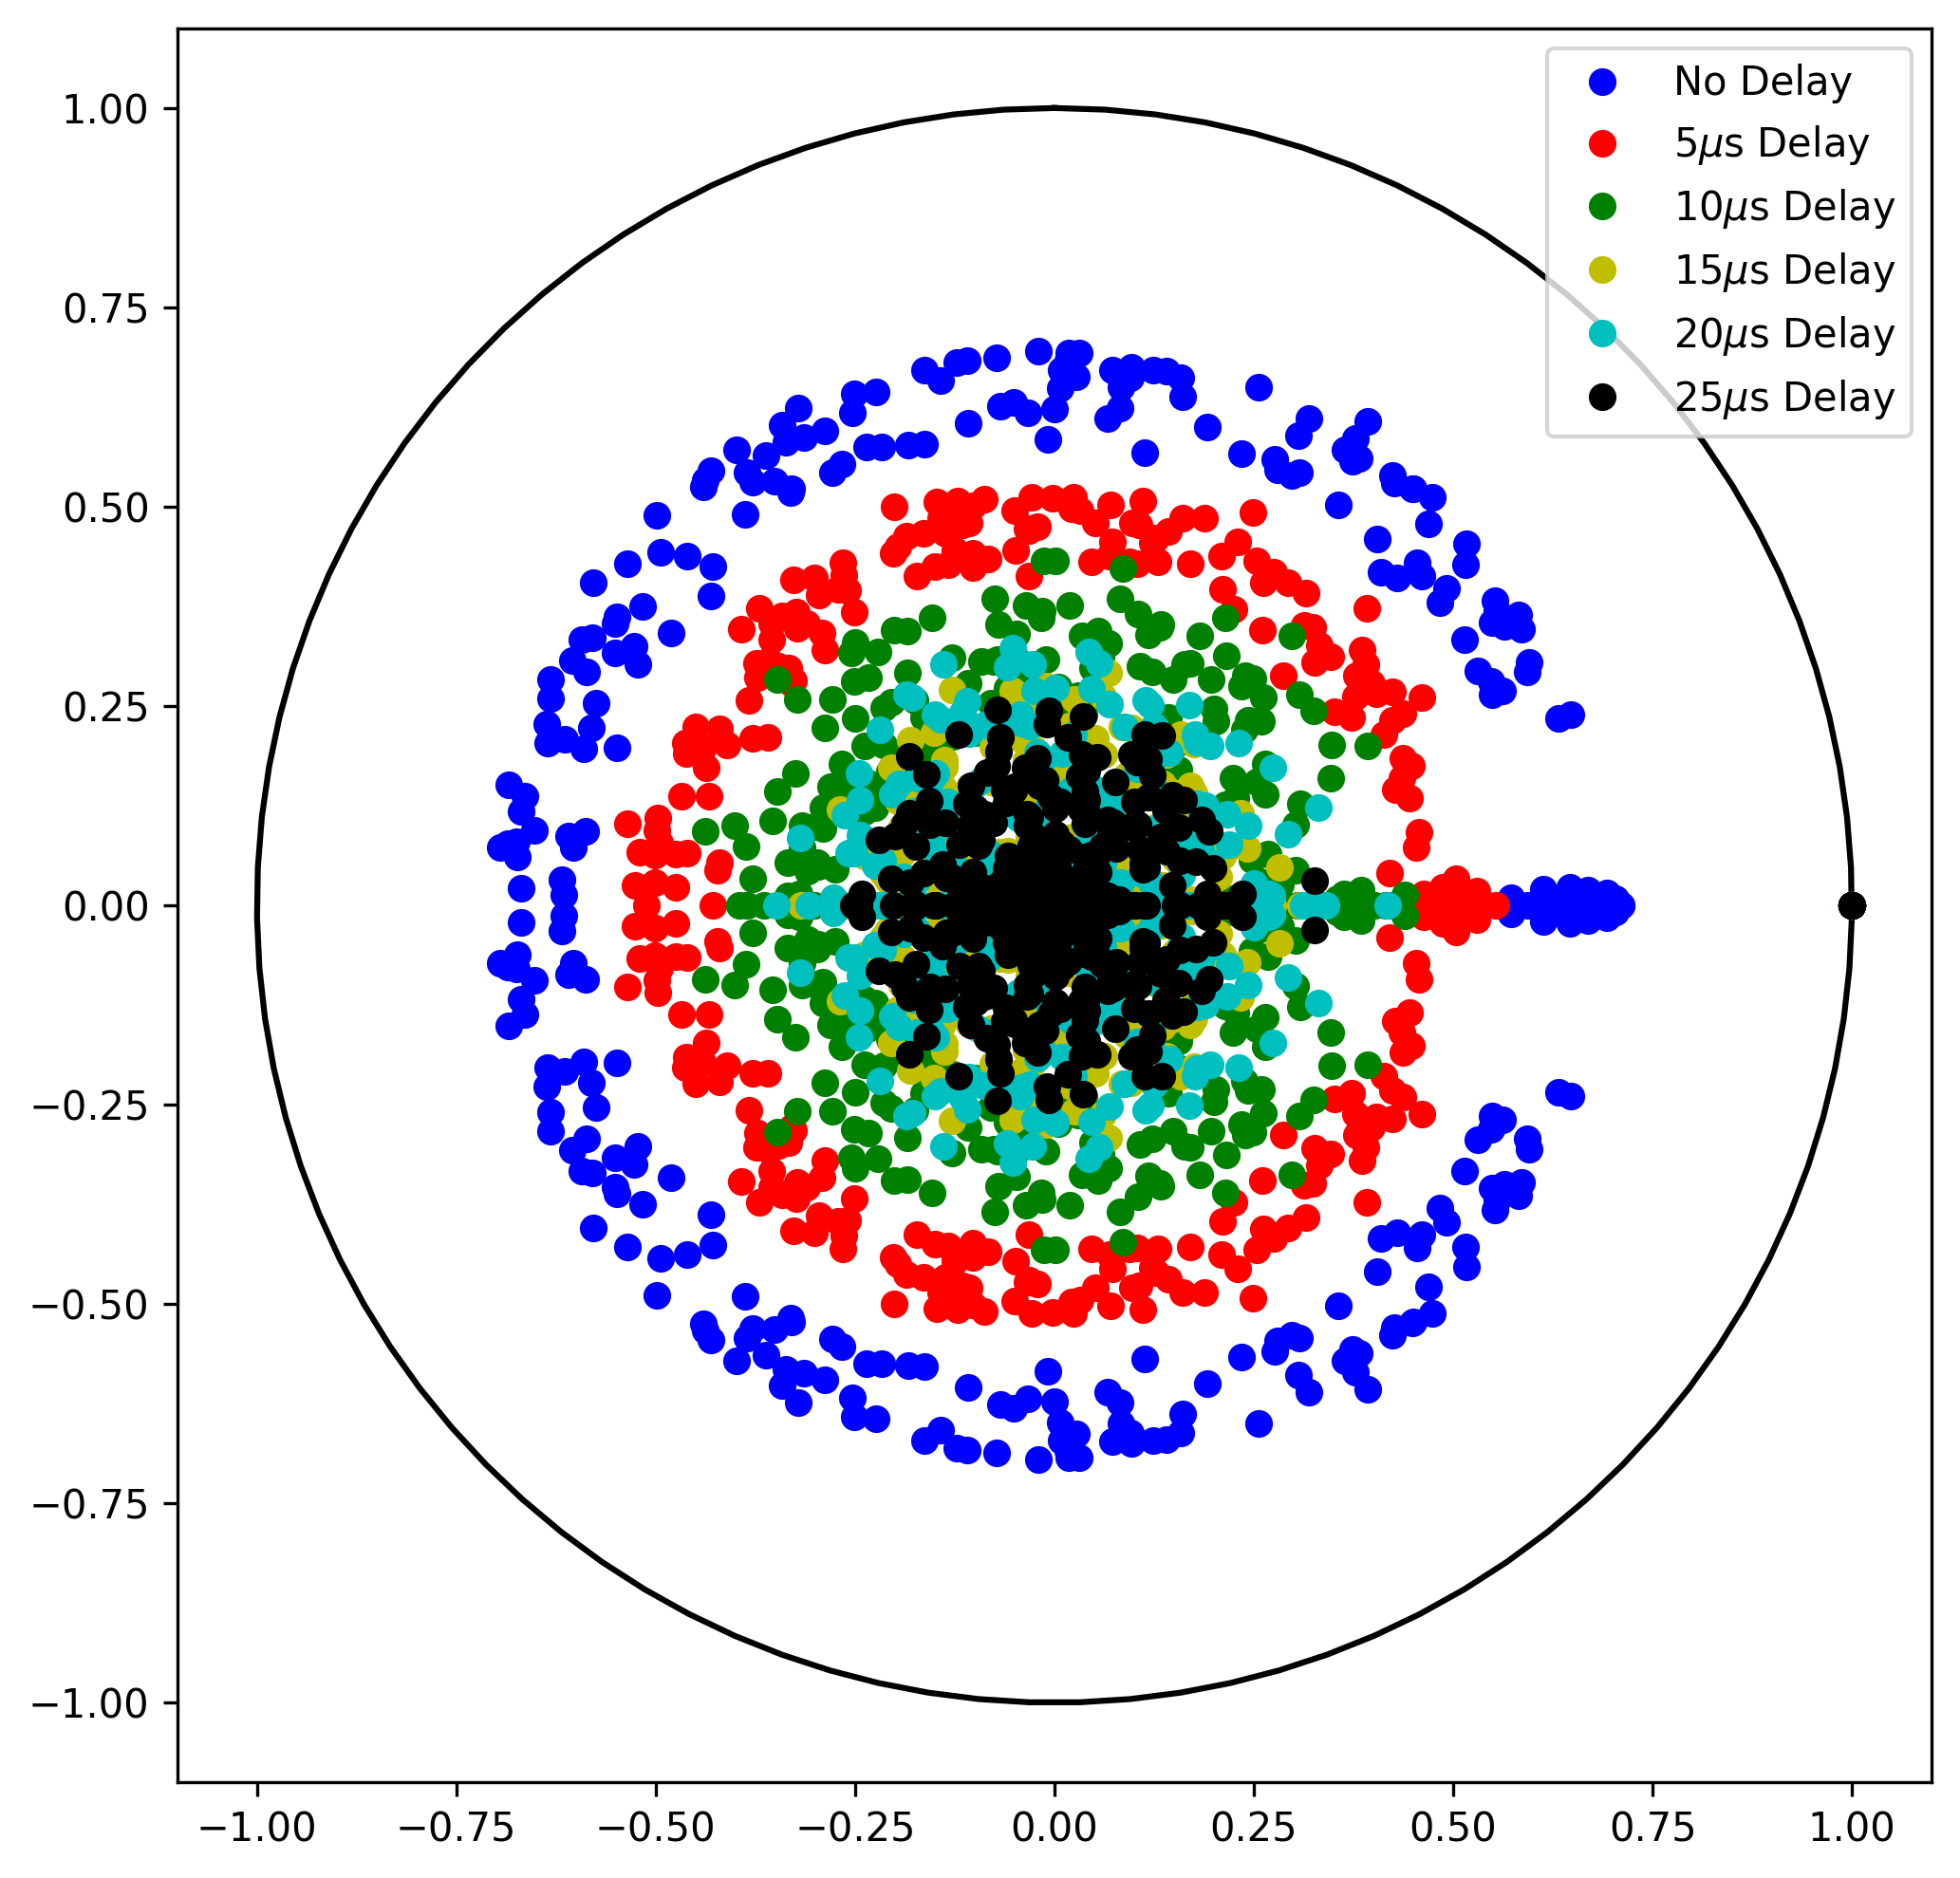

In [132]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

spectrum6 = [np.concatenate([spectrum[:,0] for spectrum in spectrum6_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum6_list])]

#for spectrum in spectrum1_list:
#    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
plt.plot(*spectrum1, "bo")
plt.plot(*spectrum2, "ro")
plt.plot(*spectrum3, "go")
plt.plot(*spectrum4, "yo")
plt.plot(*spectrum5, "co")
plt.plot(*spectrum6, "ko")
    
plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.show()

## Three Qubits, Ring Radii

In [133]:
R_p1, R_m1, R_pStd1, R_mStd1 = find_outer_inner_R([spectrum1_list[i][:-1] for i in range(5)])
R_p2, R_m2, R_pStd2, R_mStd2 = find_outer_inner_R([spectrum2_list[i][:-1] for i in range(5)])
R_p3, R_m3, R_pStd3, R_mStd3 = find_outer_inner_R([spectrum3_list[i][:-1] for i in range(5)])
R_p4, R_m4, R_pStd4, R_mStd4 = find_outer_inner_R([spectrum4_list[i][:-1] for i in range(5)])
R_p5, R_m5, R_pStd5, R_mStd5 = find_outer_inner_R([spectrum5_list[i][:-1] for i in range(5)])
R_p6, R_m6, R_pStd6, R_mStd6 = find_outer_inner_R([spectrum6_list[i][:-1] for i in range(5)])

In [134]:
x = [0, 5, 10, 15, 20, 25]
R_plus = [R_p1, R_p2, R_p3, R_p4, R_p5, R_p6]
R_minus = [R_m1, R_m2, R_m3, R_m4, R_m5, R_m6]
R_plus_std = [R_pStd1, R_pStd2, R_pStd3, R_pStd4, R_pStd5, R_pStd6]
R_minus_std = [R_mStd1, R_mStd2, R_mStd3, R_mStd4, R_mStd5, R_mStd6]

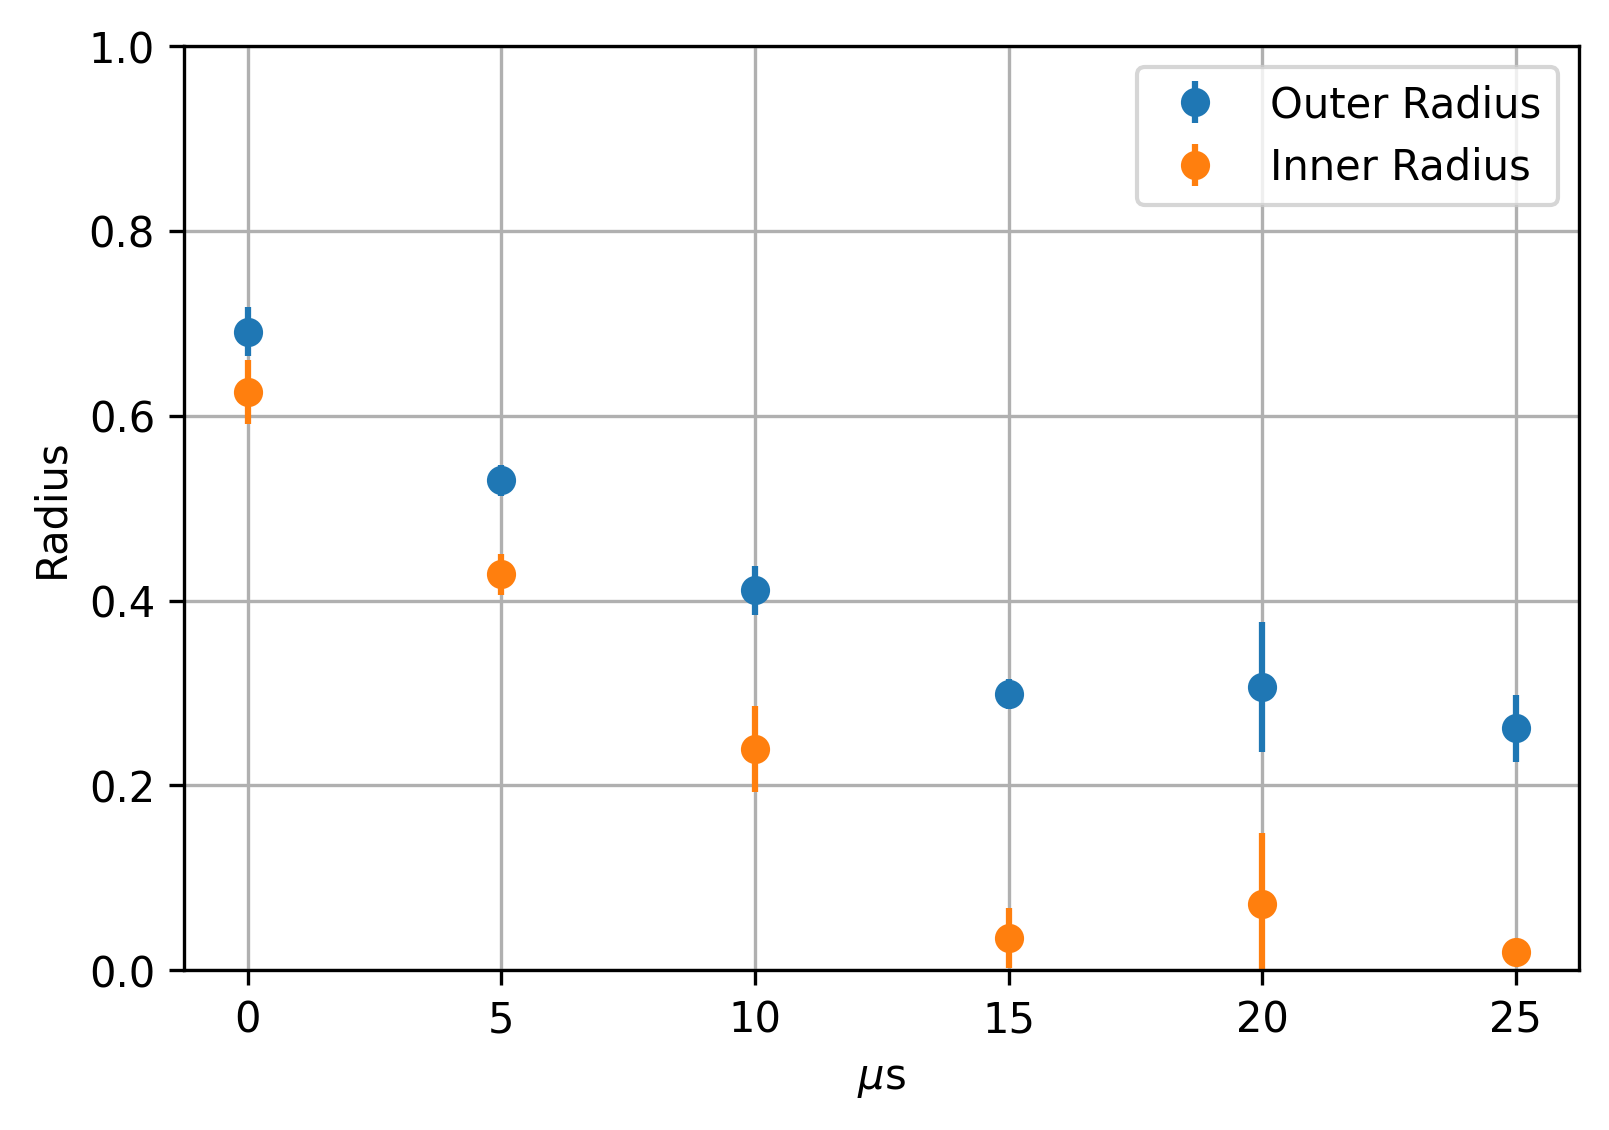

In [135]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, R_plus, yerr=R_plus_std, fmt="o")
plt.errorbar(x, R_minus, yerr=R_minus_std, fmt="o")
plt.ylim([0,1])
plt.grid()
plt.xlabel("$\mu$s")
plt.ylabel("Radius")
plt.legend(["Outer Radius", "Inner Radius"])
plt.show()

## Three Qubits, Angular Distibution

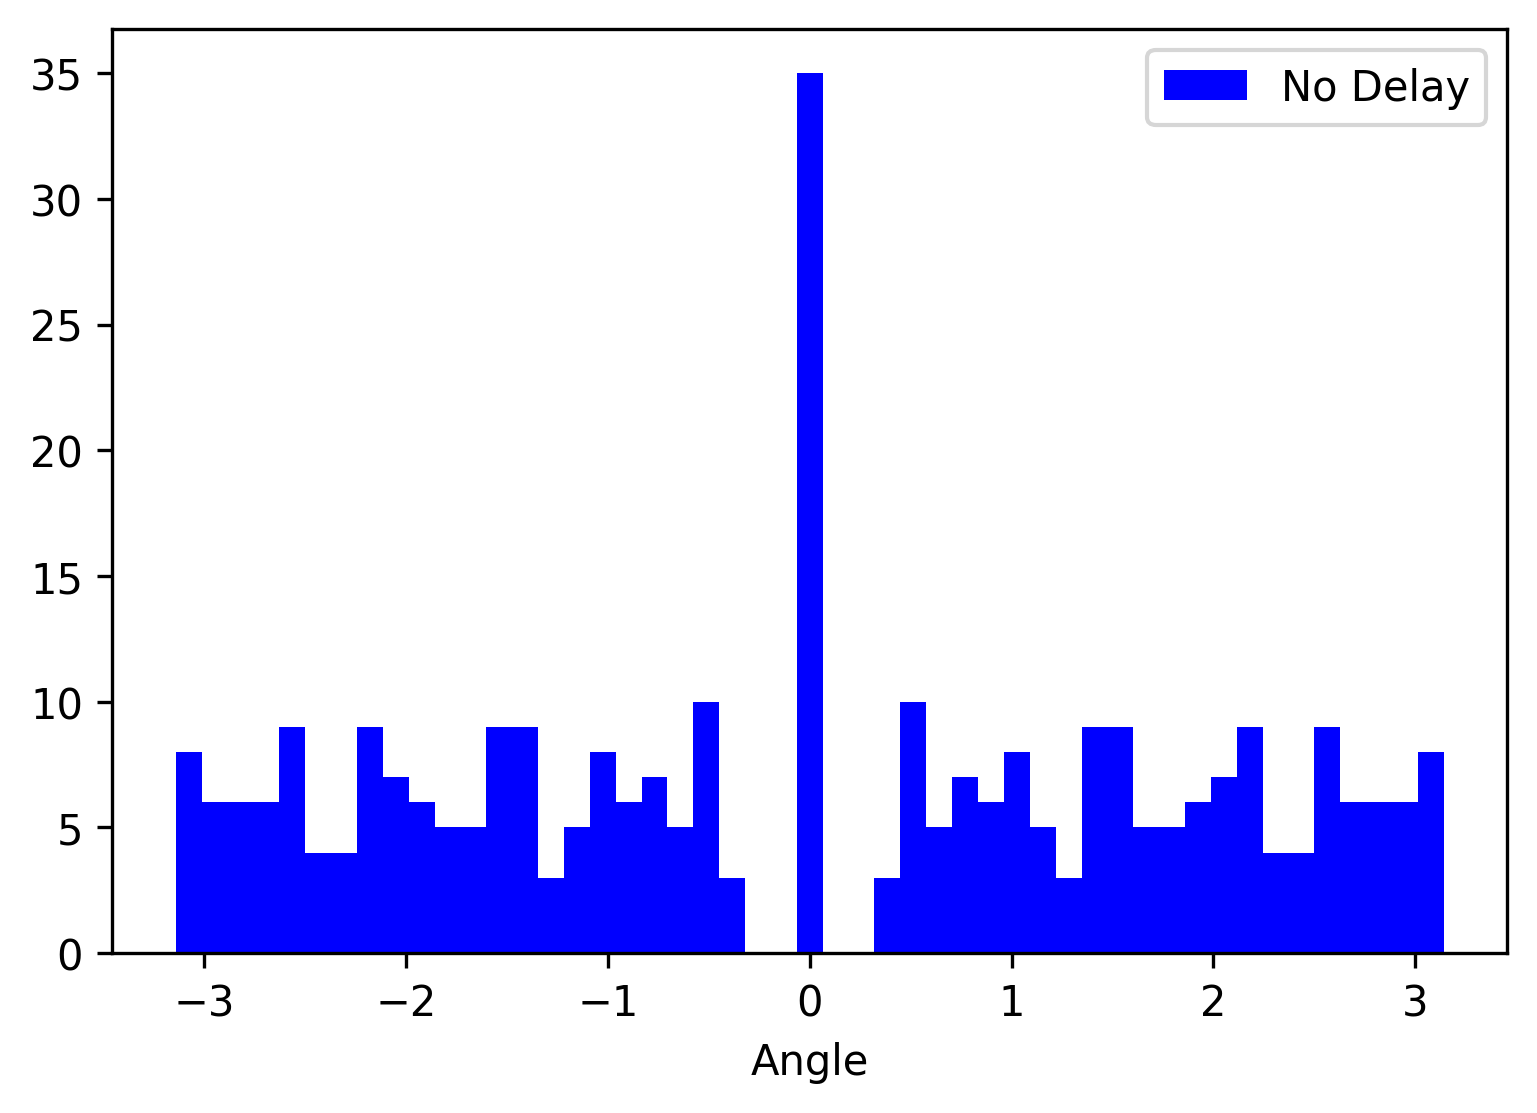

In [123]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

angular_histogram(spectrum1_list, bins=np.linspace(-np.pi, np.pi, 50))
plt.xlabel("Angle")
plt.legend(["No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")
plt.show()

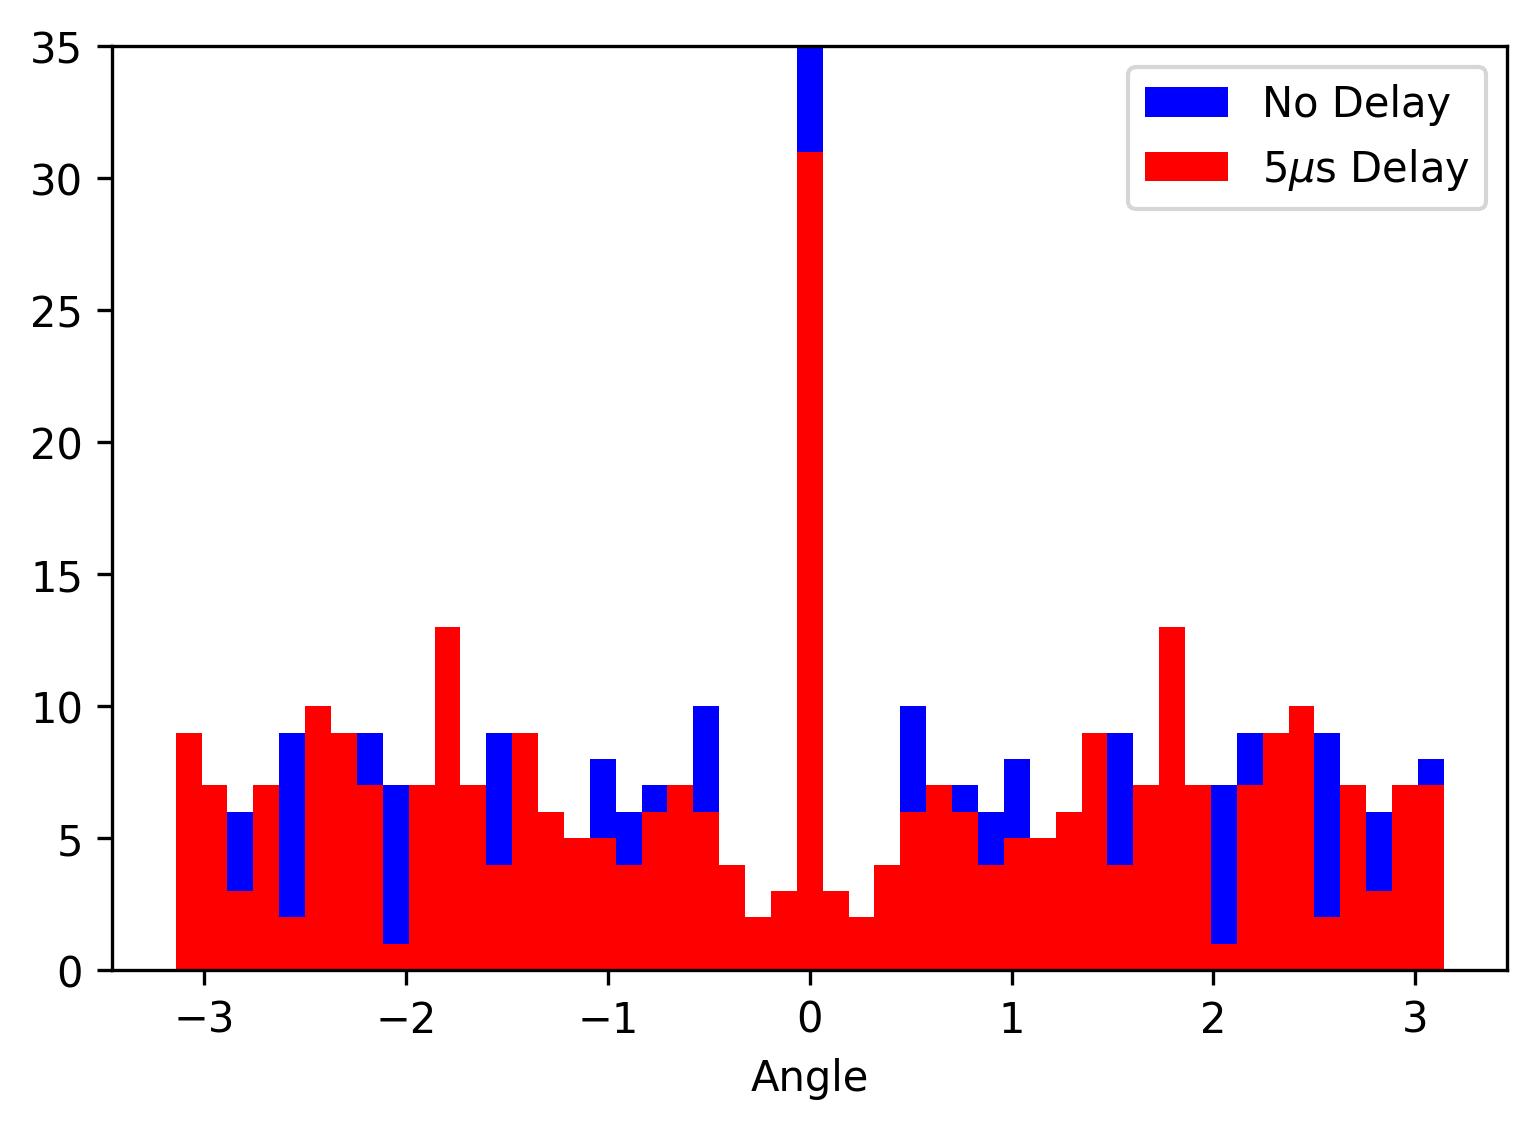

In [125]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

angular_histogram(spectrum1_list, bins=np.linspace(-np.pi, np.pi, 50))
angular_histogram(spectrum2_list, bins=np.linspace(-np.pi, np.pi, 50), color="r")
plt.legend(["No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.ylim([0,35])
plt.xlabel("Angle")
plt.show()

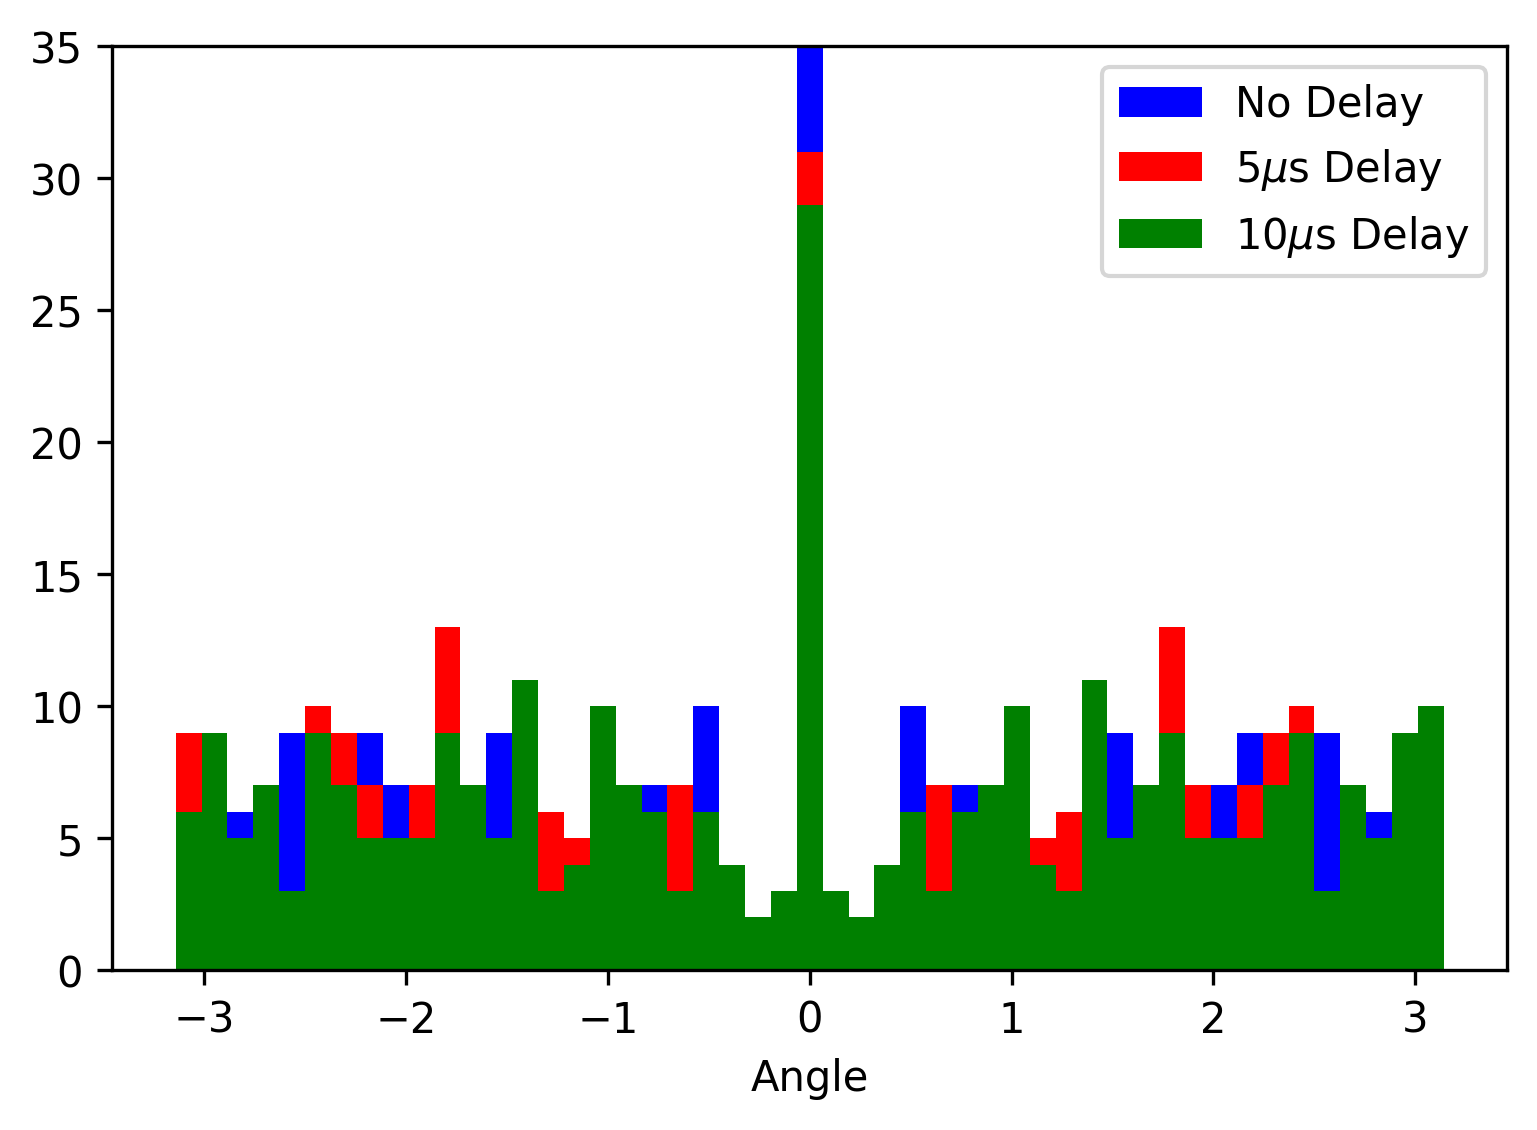

In [126]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

angular_histogram(spectrum1_list, bins=np.linspace(-np.pi, np.pi, 50))
angular_histogram(spectrum2_list, bins=np.linspace(-np.pi, np.pi, 50), color="r")
angular_histogram(spectrum3_list, bins=np.linspace(-np.pi, np.pi, 50), color="g")
plt.legend(["No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.ylim([0,35])
plt.xlabel("Angle")
plt.show()

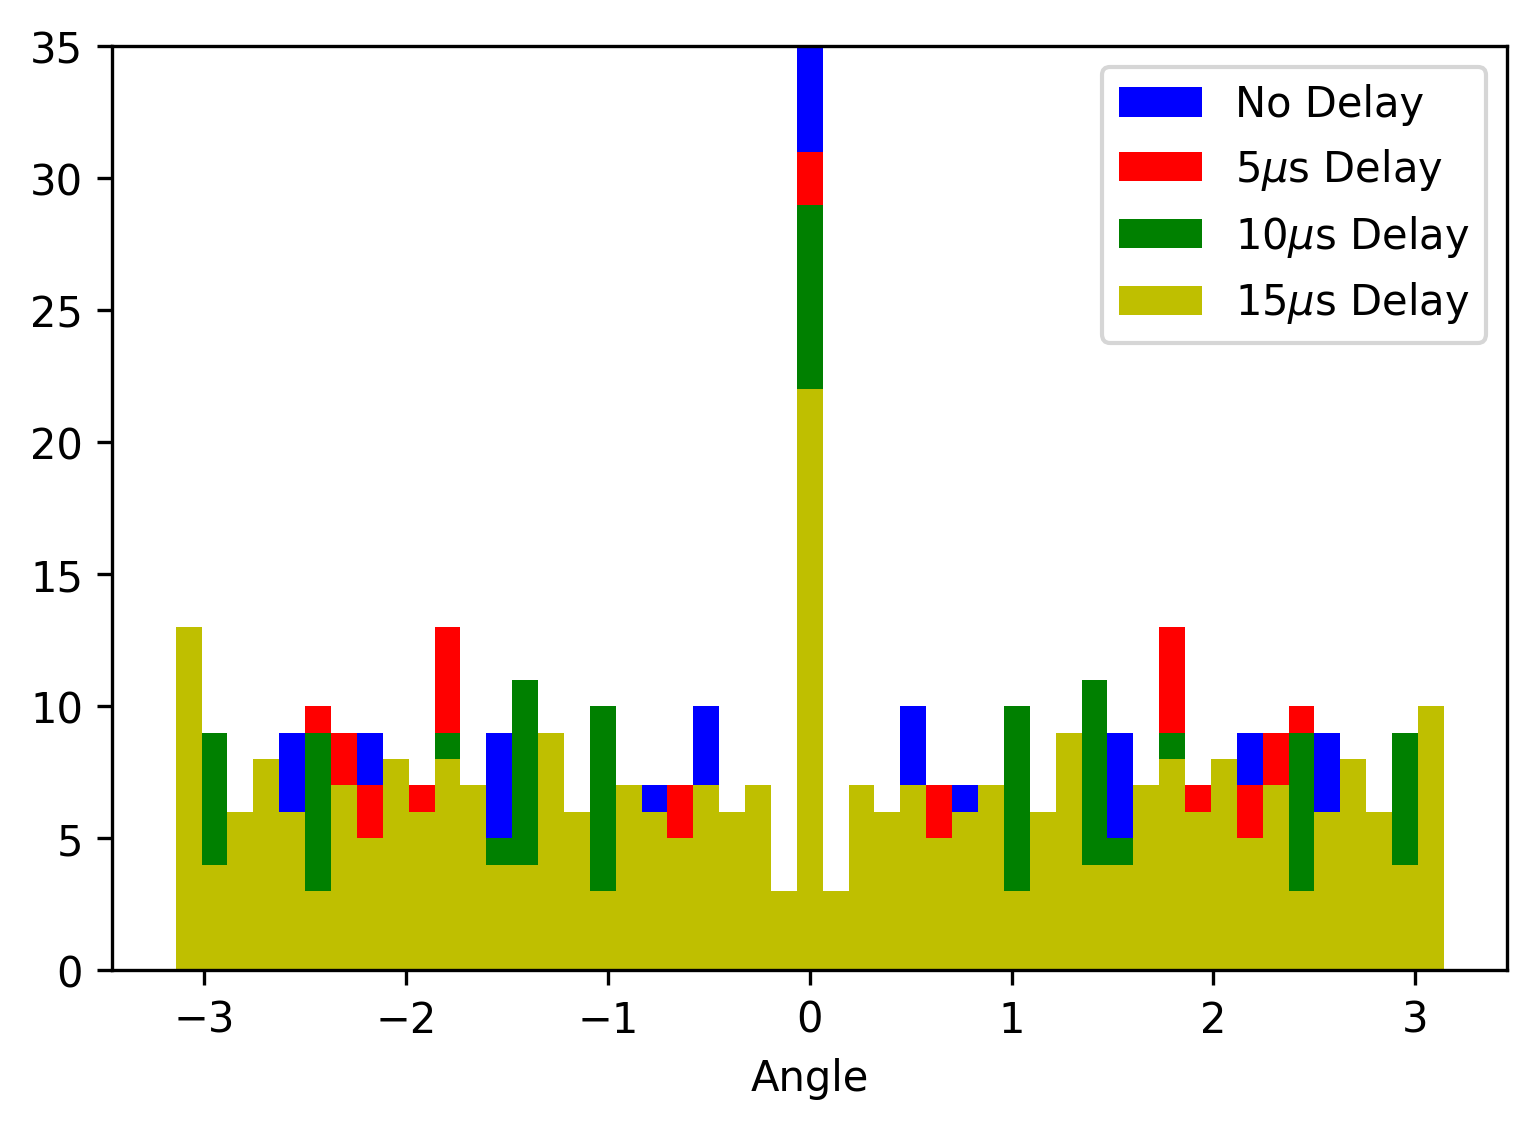

In [136]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

angular_histogram(spectrum1_list, bins=np.linspace(-np.pi, np.pi, 50))
angular_histogram(spectrum2_list, bins=np.linspace(-np.pi, np.pi, 50), color="r")
angular_histogram(spectrum3_list, bins=np.linspace(-np.pi, np.pi, 50), color="g")
angular_histogram(spectrum4_list, bins=np.linspace(-np.pi, np.pi, 50), color="y")
plt.legend(["No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.ylim([0,35])
plt.xlabel("Angle")
plt.show()

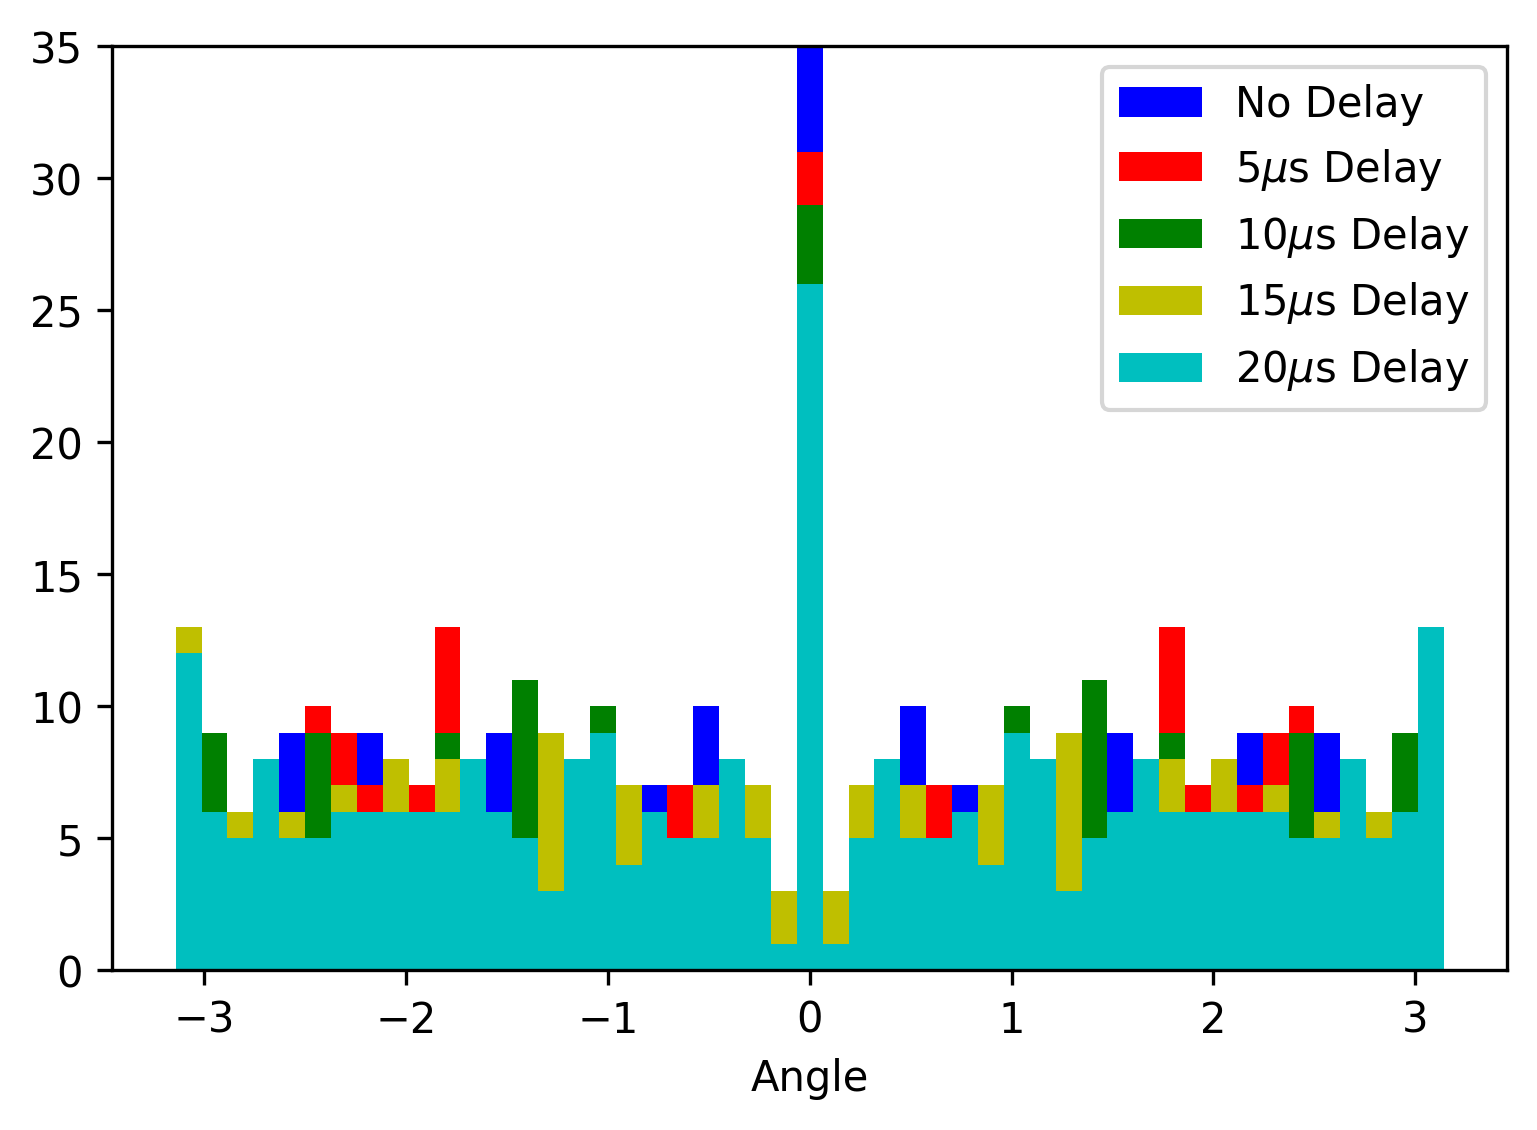

In [137]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

angular_histogram(spectrum1_list, bins=np.linspace(-np.pi, np.pi, 50))
angular_histogram(spectrum2_list, bins=np.linspace(-np.pi, np.pi, 50), color="r")
angular_histogram(spectrum3_list, bins=np.linspace(-np.pi, np.pi, 50), color="g")
angular_histogram(spectrum4_list, bins=np.linspace(-np.pi, np.pi, 50), color="y")
angular_histogram(spectrum5_list, bins=np.linspace(-np.pi, np.pi, 50), color="c")
plt.legend(["No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.ylim([0,35])
plt.xlabel("Angle")
plt.show()

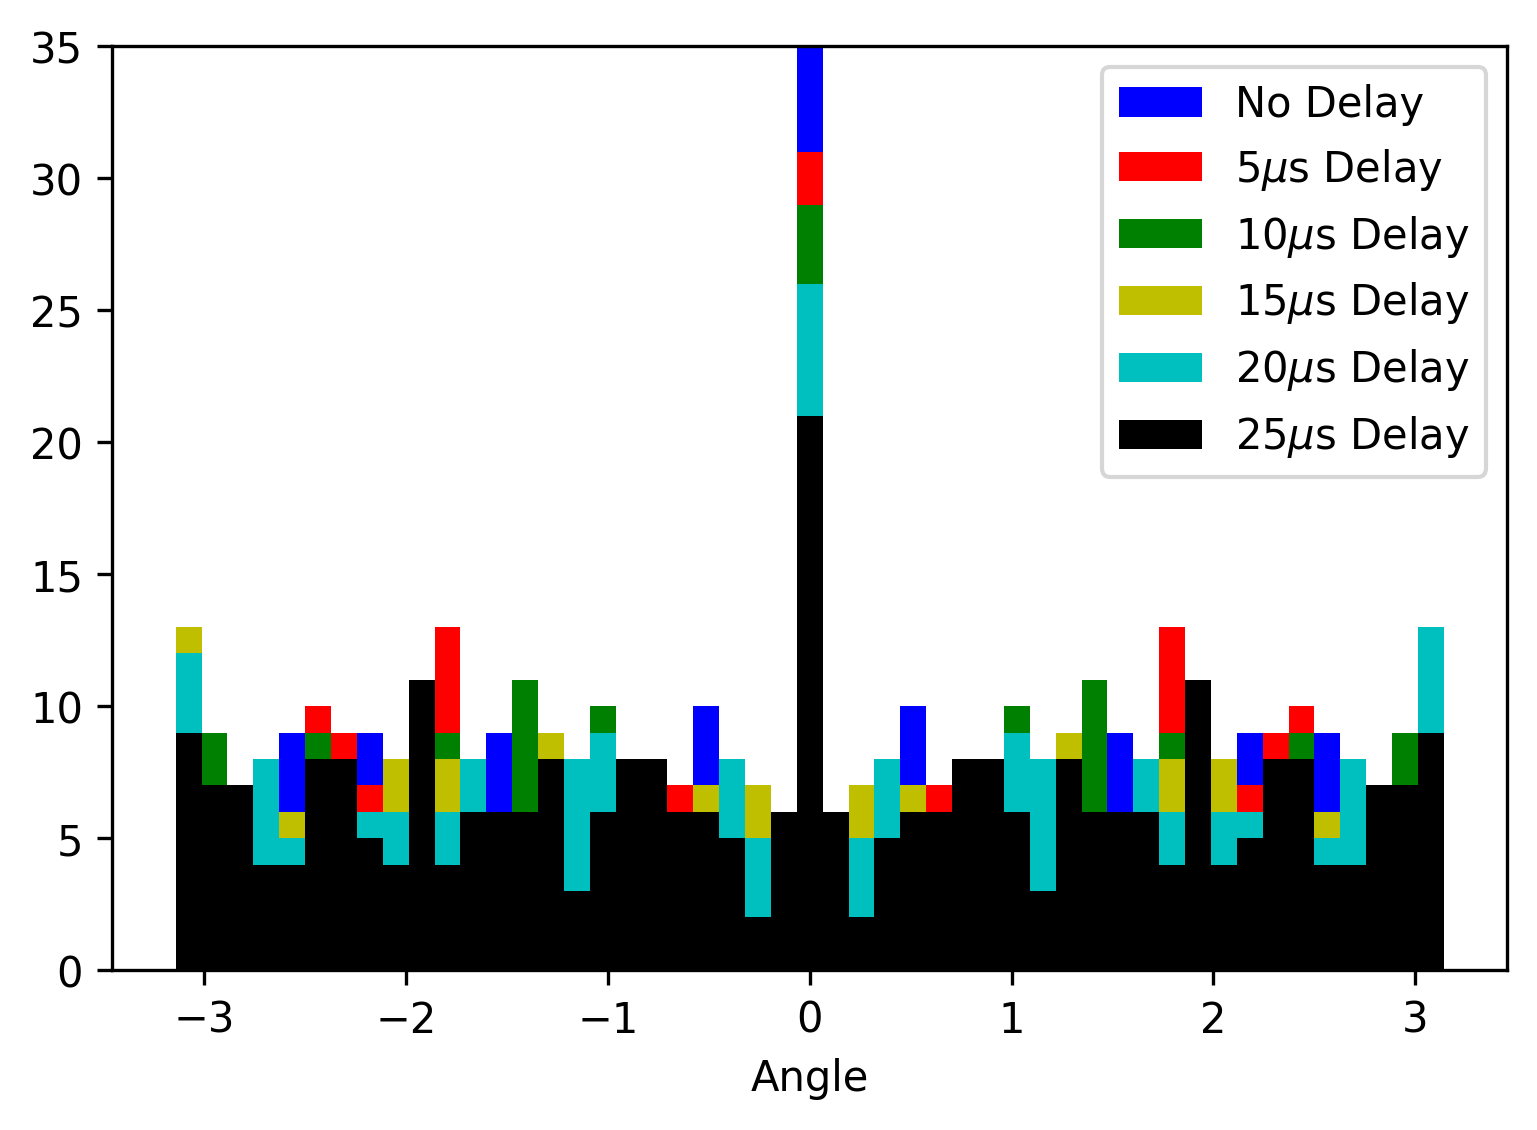

In [141]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

angular_histogram(spectrum1_list, bins=np.linspace(-np.pi, np.pi, 50))
angular_histogram(spectrum2_list, bins=np.linspace(-np.pi, np.pi, 50), color="r")
angular_histogram(spectrum3_list, bins=np.linspace(-np.pi, np.pi, 50), color="g")
angular_histogram(spectrum4_list, bins=np.linspace(-np.pi, np.pi, 50), color="y")
angular_histogram(spectrum5_list, bins=np.linspace(-np.pi, np.pi, 50), color="c")
angular_histogram(spectrum6_list, bins=np.linspace(-np.pi, np.pi, 50), color="k")
plt.legend(["No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.ylim([0,35])
plt.xlabel("Angle")
plt.show()

## Entangling Dissipation

In [34]:
inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_decay_belem.p", "rb"))
n=3
d=2**n

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

inputs_spam, targets_spam, inputs_map, targets_map = data
    
spam = SPAM(init = InitialState(d, c=None),
            povm = CorruptionMatrix(d, c=None),
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
              num_iter = 300,
              verbose = False,
              )

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 4000,
           verbose = False,
          )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=64,
                                           spam = spam,
                                              ),
                           loss_function = KLDiv(),
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           logger = Logger(loss_function = KLDiv()),
                           )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 4000,
            N = 500,
            )  

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.00120224458188956


  0%|          | 0/4000 [00:00<?, ?it/s]

0.17520080863073825 None
0.051339291823615116 None
0.01094242922360413 None
0.0054420483183453515 None
0.004669214351846201 None
0.004455027144328065 None
0.004367389258912332 None
0.004328424326211747 None
0.004306659646876835 None
0.004292622402224028 None
0.004287488877216458 None
0.004288371802575764 None
0.004279146939240653 None
0.004275688199670561 None
0.004278337580938259 None
0.004276545350870881 None
0.004274922194898518 None
0.004275245613340247 None
0.004274565900037891 None
0.00427763559554252 None
0.0042746279344890534 None
0.004274133710405 None
0.004275900363873289 None
0.004284325847195783 None
0.004280178303464421 None
0.004280366912736685 None
0.0042832083716806075 None
0.004278306773295154 None
0.004277517145230377 None
0.004280336690609022 None
0.0042788792986717585 None
0.004281470075989485 None
0.0042794401975567685 None
0.00427890567852213 None
0.00428082173694202 None
0.004283239008014911 None
0.0042848773114979415 None
0.004282106517724108 None
0.004283516272

In [35]:
X, A, B = generate_ginibre(2, 2, trainable=True)
X, C, D = generate_ginibre(2, 2, trainable=True)
X, E, F = generate_ginibre(2, 2, trainable=True)

In [36]:
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for i in range(2000):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([A,B,C,D,E,F])
        
        
        X1 = tf.cast(A, dtype=precision) + 1j*tf.cast(B, dtype=precision)
        XX1 = tf.matmul(X1, X1, adjoint_b=True)
        state1 = XX1/tf.linalg.trace(XX1)
        
        X2 = tf.cast(C, dtype=precision) + 1j*tf.cast(D, dtype=precision)
        XX2 = tf.matmul(X2, X2, adjoint_b=True)
        state2 = XX2/tf.linalg.trace(XX2)
        
        X3 = tf.cast(E, dtype=precision) + 1j*tf.cast(F, dtype=precision)
        XX3 = tf.matmul(X3, X3, adjoint_b=True)
        state3 = XX3/tf.linalg.trace(XX3)

        
        state = tf.expand_dims(kron(state1,state2,state3), axis=0)

        state = model.channel.apply_channel(state)
        state = partial_transpose(state, qubit=0)

        eig, _ = tf.linalg.eigh(state)
        eig = tf.math.real(eig)
        loss = tf.math.reduce_min(eig) + tf.math.reduce_sum(eig[eig<0]) - tf.math.reduce_min(eig[eig<0])
        grads = tape.gradient(loss, [A,B,C,D,E,F])
        optimizer.apply_gradients(zip(grads, [A,B,C,D,E,F]))
        print(loss.numpy())

-0.040133966465283624
-0.04502381937029837
-0.049888628167318275
-0.054731524983705225
-0.059557650133492165
-0.06436560588253404
-0.06915461608416884
-0.07392522802680139
-0.0786765850556023
-0.08340484304284418
-0.08810370336291186
-0.0927655129190743
-0.09738202366083008
-0.10194478802022522
-0.10644535370991845
-0.11087536725548497
-0.11522663834691294
-0.11949118748393381
-0.12366128669369203
-0.12772949812675366
-0.13168871353537448
-0.13553219698600683
-0.13925363276749514
-0.1428471799427911
-0.1463075342215593
-0.1496299968129992
-0.15281054874584765
-0.15584592794813112
-0.15873370529763642
-0.1614723549973813
-0.1640613140781325
-0.16650102563276314
-0.16879296057791898
-0.1709396133443271
-0.17294446794738794
-0.17481193241585619
-0.17654724157833757
-0.17815633069445883
-0.17964568521946397
-0.18102217476472343
-0.1822928815174443
-0.18346493438916028
-0.1845453595287722
-0.1855409555499135
-0.1864581983877515
-0.1873031769580054
-0.1880815575733348
-0.18879857289868796
-0

-0.20600264757957445
-0.2060086784466845
-0.20601463973543332
-0.20602053177671756
-0.20602635490765028
-0.20603210947147135
-0.20603779581745232
-0.2060434143007994
-0.20604896528255584
-0.20605444912949764
-0.2060598662140334
-0.20606521691409654
-0.20607050161303797
-0.20607572069951877
-0.20608087456739688
-0.20608596361561318
-0.20609098824807898
-0.20609594887355911
-0.20610084590555264
-0.20610567976217514
-0.20611045086603605
-0.20611515964411836
-0.2061198065276536
-0.2061243919520003
-0.20612891635651315
-0.206133380184422
-0.20613778388269993
-0.20614212790193776
-0.20614641269621398
-0.20615063872296413
-0.20615480644285056
-0.20615891631963312
-0.20616296882003374
-0.2061669644136111
-0.20617090357262194
-0.20617478677189047
-0.2061786144886798
-0.2061823872025532
-0.20618610539524662
-0.20618976955053292
-0.20619338015409155
-0.20619693769337563
-0.20620044265747872
-0.20620389553700616
-0.2062072968239425
-0.2062106470115198
-0.20621394659409154
-0.20621719606699915
-0.2

-0.2063876436067938
-0.2063876438909301
-0.20638764416527947
-0.20638764443016663
-0.2063876446859085
-0.20638764493280937
-0.2063876451711647
-0.20638764540125967
-0.20638764562337086
-0.20638764583776745
-0.20638764604470825
-0.20638764624444195
-0.20638764643721333
-0.20638764662325643
-0.20638764680279742
-0.20638764697605777
-0.2063876471432484
-0.20638764730457568
-0.20638764746023874
-0.2063876476104294
-0.20638764775533344
-0.20638764789513234
-0.20638764802999868
-0.2063876481601017
-0.20638764828560308
-0.20638764840666196
-0.20638764852342942
-0.20638764863605283
-0.20638764874467477
-0.2063876488494329
-0.2063876489504601
-0.20638764904788476
-0.2063876491418316
-0.20638764923242142
-0.20638764931976877
-0.20638764940398768
-0.206387649485186
-0.2063876495634679
-0.206387649638936
-0.20638764971168763
-0.2063876497818184
-0.2063876498494186
-0.20638764991457703
-0.20638764997737935
-0.20638765003790874
-0.20638765009624294
-0.2063876501524613
-0.20638765020663744
-0.2063876

-0.2063876515994225
-0.2063876515994222
-0.20638765159942252
-0.20638765159942243
-0.2063876515994226
-0.2063876515994228
-0.20638765159942218
-0.20638765159942254
-0.20638765159942243
-0.2063876515994217
-0.20638765159942246
-0.2063876515994224
-0.20638765159942257
-0.20638765159942243
-0.20638765159942285
-0.20638765159942263
-0.20638765159942285
-0.2063876515994223
-0.20638765159942235
-0.20638765159942277
-0.20638765159942243
-0.2063876515994226
-0.2063876515994222
-0.20638765159942282
-0.20638765159942238
-0.2063876515994225
-0.20638765159942257
-0.2063876515994223
-0.20638765159942257
-0.20638765159942252
-0.2063876515994225
-0.20638765159942257
-0.2063876515994223
-0.20638765159942257
-0.2063876515994222
-0.20638765159942235
-0.2063876515994223
-0.20638765159942224
-0.20638765159942257
-0.20638765159942274
-0.2063876515994224
-0.20638765159942263
-0.20638765159942277
-0.2063876515994224
-0.20638765159942285
-0.20638765159942232
-0.2063876515994227
-0.20638765159942216
-0.2063876

-0.20638765159942243
-0.20638765159942252
-0.20638765159942238
-0.20638765159942232
-0.20638765159942243
-0.20638765159942263
-0.20638765159942266
-0.20638765159942266
-0.20638765159942274
-0.20638765159942268
-0.20638765159942232
-0.20638765159942238
-0.20638765159942268
-0.2063876515994227
-0.20638765159942268
-0.20638765159942282
-0.20638765159942307
-0.20638765159942257
-0.2063876515994226
-0.20638765159942268
-0.20638765159942277
-0.2063876515994226
-0.20638765159942277
-0.20638765159942266
-0.2063876515994225
-0.20638765159942235
-0.2063876515994225
-0.2063876515994224
-0.20638765159942246
-0.20638765159942263
-0.20638765159942235
-0.20638765159942257
-0.20638765159942243
-0.20638765159942238
-0.20638765159942257
-0.20638765159942266
-0.2063876515994228
-0.2063876515994224
-0.2063876515994224
-0.20638765159942266
-0.20638765159942252
-0.20638765159942252
-0.20638765159942252
-0.20638765159942252
-0.20638765159942274
-0.20638765159942254
-0.20638765159942235
-0.2063876515994226
-0

-0.20638765159942235
-0.20638765159942252
-0.20638765159942243
-0.20638765159942266
-0.20638765159942243
-0.20638765159942243
-0.2063876515994226
-0.20638765159942254
-0.20638765159942263
-0.20638765159942246


In [37]:
state = kron(state1,state2,state3)

In [42]:
print(state1)
print(state2)
print(state3)

tf.Tensor(
[[ 0.551+0.j     -0.081+0.4907j]
 [-0.081-0.4907j  0.449+0.j    ]], shape=(2, 2), dtype=complex128)
tf.Tensor(
[[0.5376+0.j     0.1812+0.4645j]
 [0.1812-0.4645j 0.4624+0.j    ]], shape=(2, 2), dtype=complex128)
tf.Tensor(
[[0.9811+0.j     0.0556-0.1242j]
 [0.0556+0.1242j 0.0189+0.j    ]], shape=(2, 2), dtype=complex128)


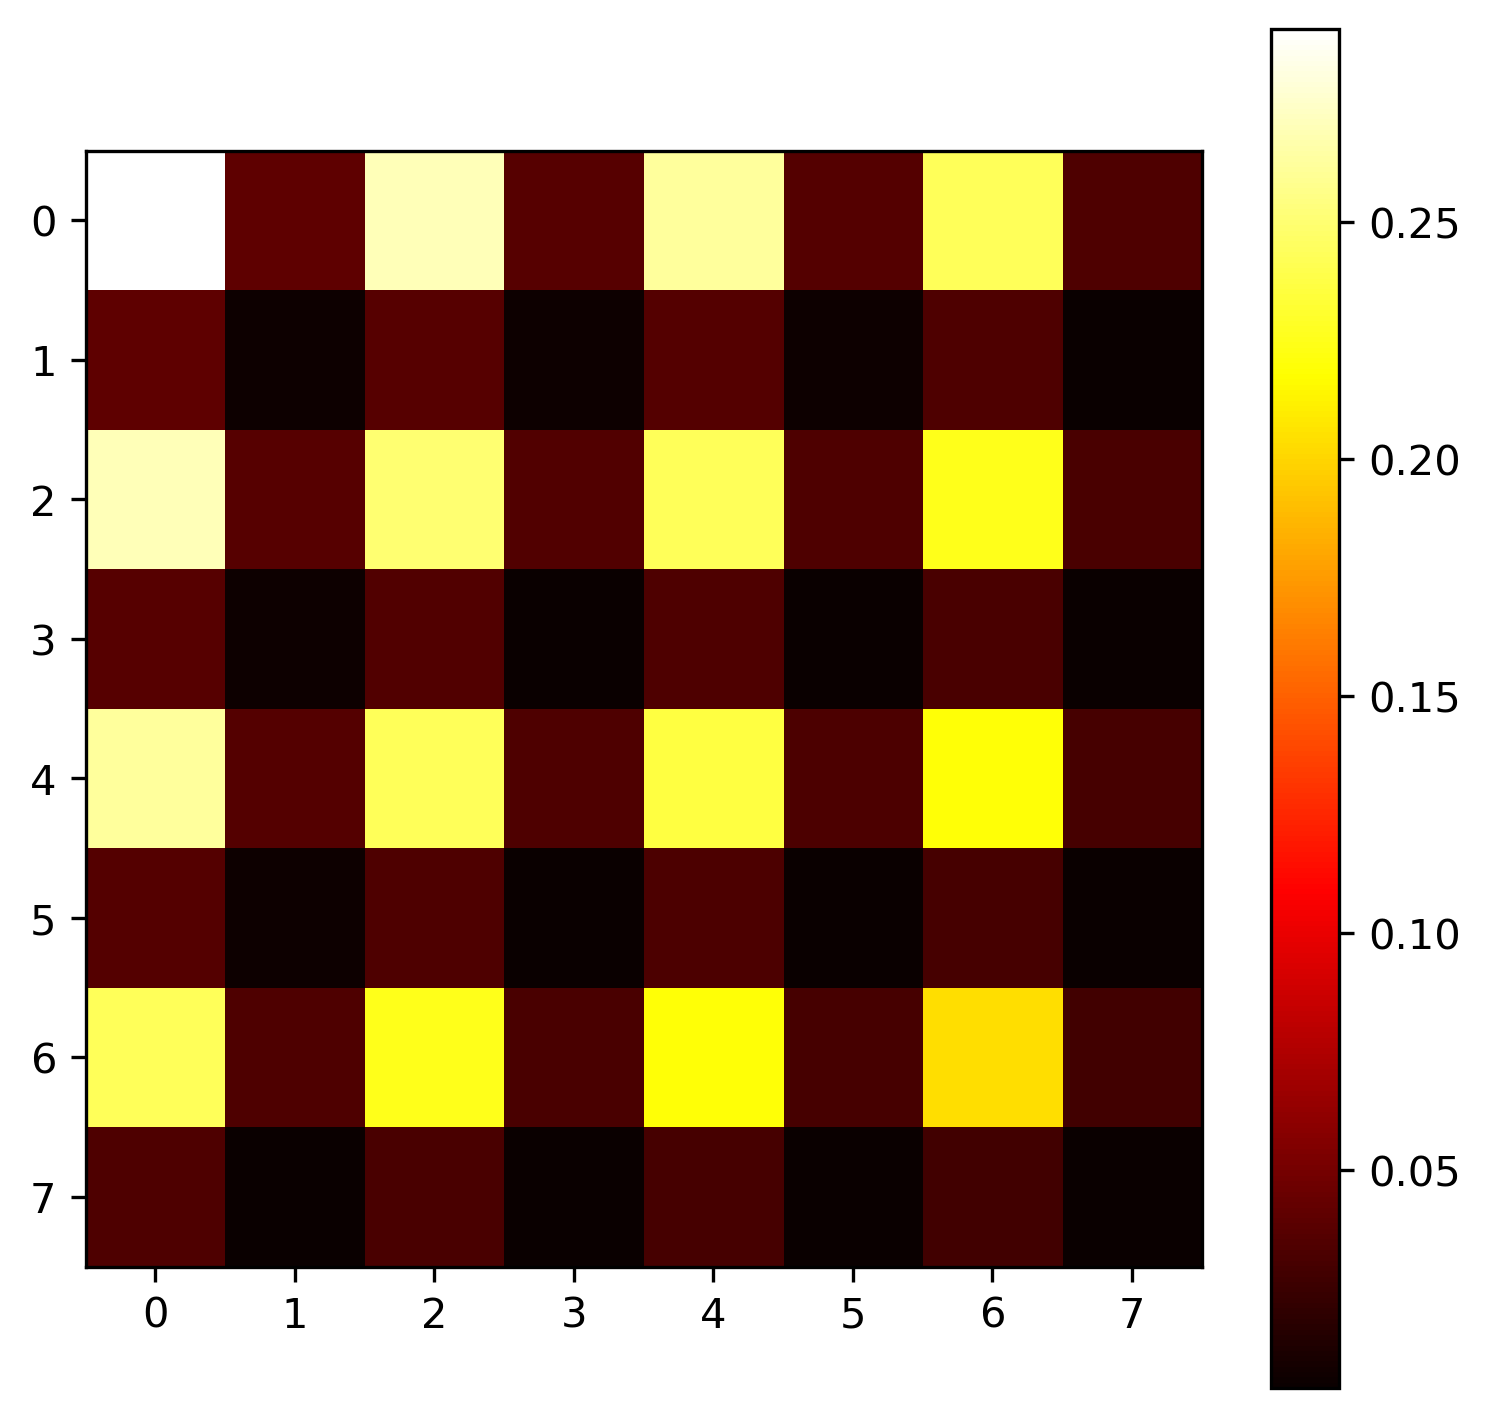

In [38]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

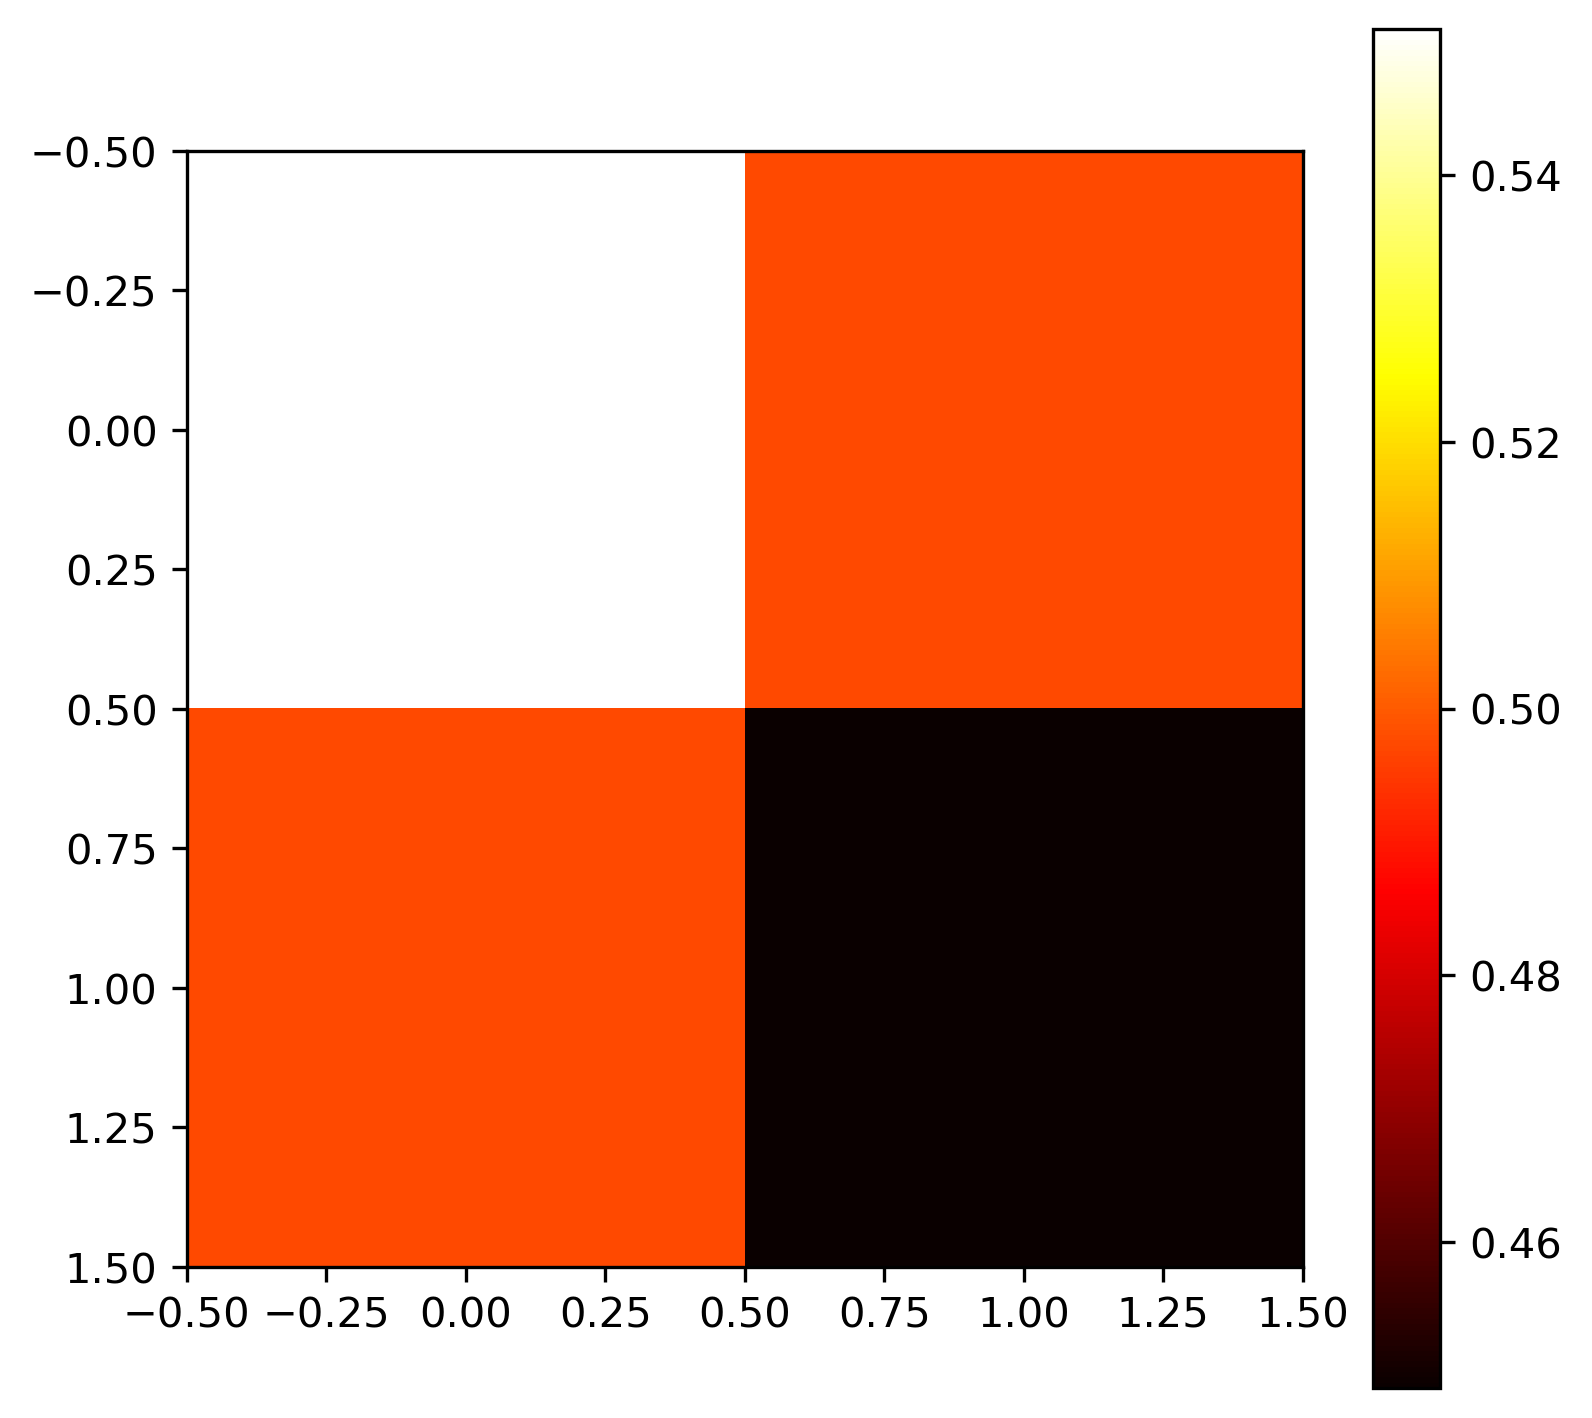

In [39]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state1), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

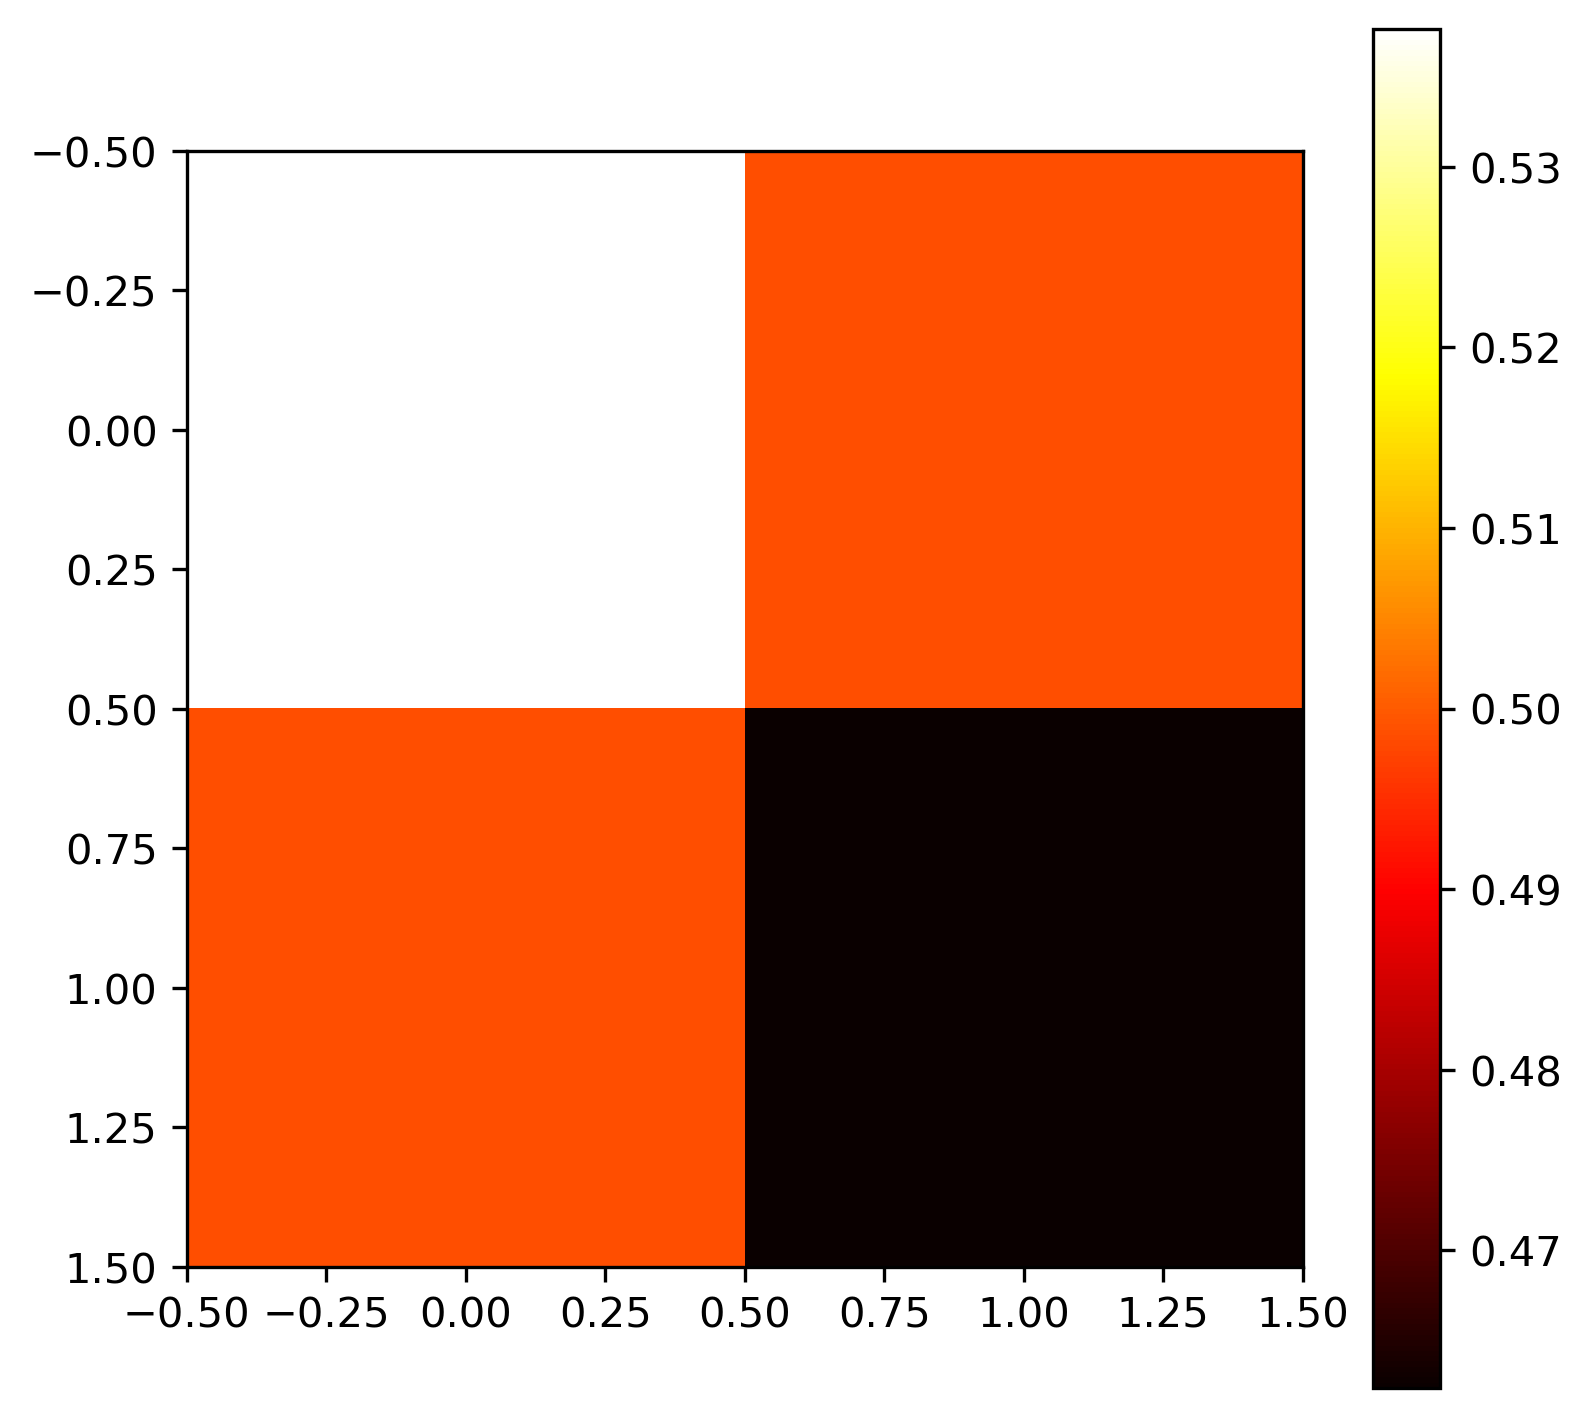

In [40]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state2), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

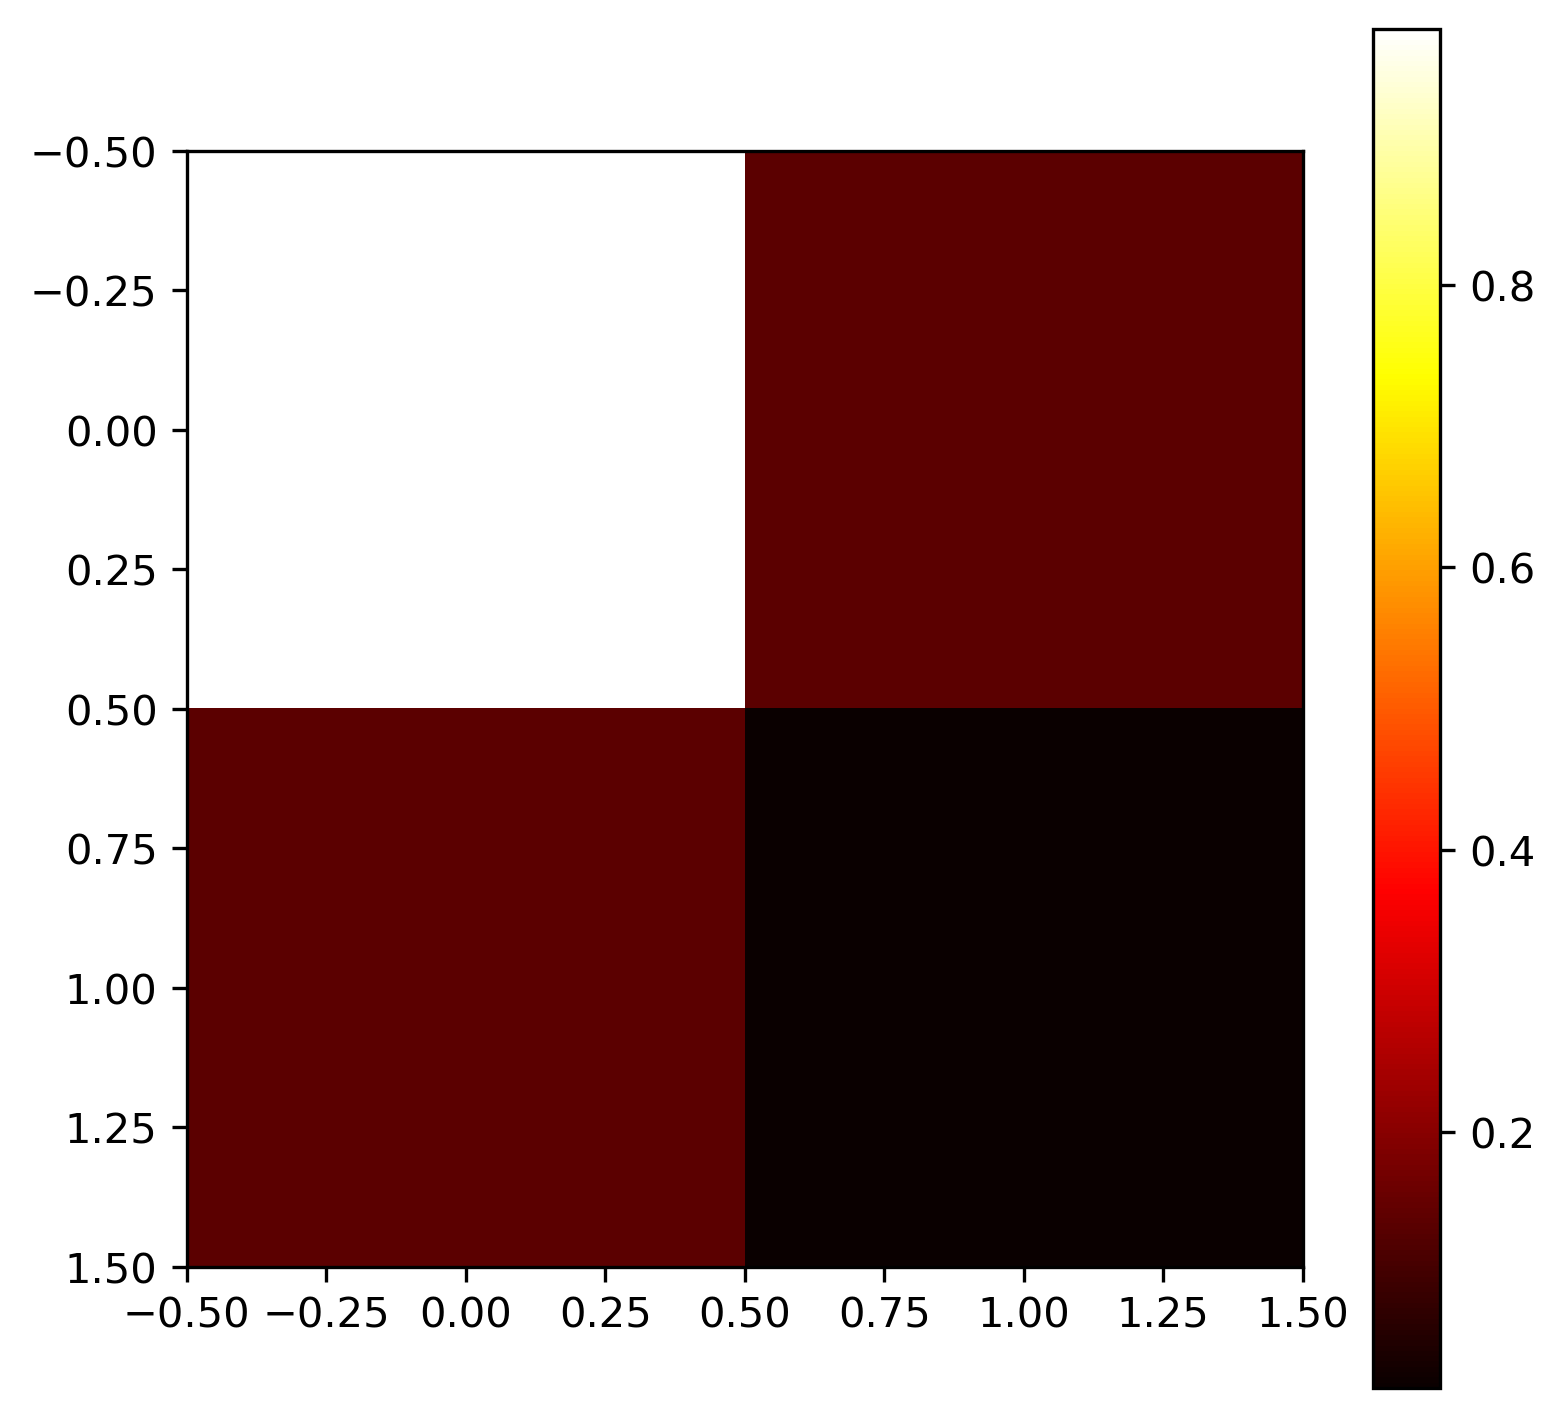

In [41]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state3), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [18]:
N = targets_map.shape[0]
d = model.channel.spam.init.shape[0]
U_prep, U_basis = inputs_map

state = tf.repeat(tf.expand_dims(model.channel.spam.init, axis=0), N, axis=0)
state = apply_unitary(state, U_prep)
state = model.channel.apply_channel(state)
output = measurement(state, U_basis, model.channel.spam.povm)

In [21]:
print(output[1], targets_map[1])

tf.Tensor(
[0.1987+8.6249e-19j 0.1471-1.7798e-18j 0.1063+1.6813e-18j
 0.0768-2.7883e-19j 0.1931+9.6475e-18j 0.1217-1.0601e-18j
 0.083 +1.9314e-18j 0.0761+1.4505e-18j], shape=(8,), dtype=complex128) tf.Tensor(
[0.215+0.j 0.145+0.j 0.107+0.j 0.078+0.j 0.166+0.j 0.129+0.j 0.07 +0.j
 0.09 +0.j], shape=(8,), dtype=complex128)


In [143]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

map_stability1 = []

for i in tqdm(range(5)):
    model = fit_model(f"threeQubits_PQC_5usDelay_belem_{i}", ratio=0.5, rank=16)
    map_stability1.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0090221323813562


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00600287005556968 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008918165075153051


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007513710624506129 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008952104705195741


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006455759819969178 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008713885043136214


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005683570207258908 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010258367333808664


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006173709838921238 None


In [144]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

map_stability2 = []

for i in tqdm(range(5)):
    model = fit_model(f"threeQubits_PQC_5usDelay_belem_{i}", ratio=0.25, rank=16)
    map_stability2.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0090221323813562


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0035734612823193576 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008918165075153051


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003737395288070825 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008952104705195741


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003981688979907088 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008713885043136214


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003644948354145094 None


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010258367333808664


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003363585000653142 None


In [149]:
data_stab1 = [model.channel for model in model_threeQubits_list2]
data_stab2 = [model.channel for model in map_stability1]
data_stab3 = [model.channel for model in map_stability2]


spectrum_stab1_list = [channel_spectrum(channel) for channel in data_stab1]
spectrum_stab2_list = [channel_spectrum(channel) for channel in data_stab2]
spectrum_stab3_list = [channel_spectrum(channel) for channel in data_stab3]

saver(spectrum_stab1_list, "spectrum_stab1_list.p")
saver(spectrum_stab2_list, "spectrum_stab2_list.p")
saver(spectrum_stab3_list, "spectrum_stab3_list.p")

In [150]:
spectrum_stab1 = [np.concatenate([spectrum[:,0] for spectrum in spectrum_stab1_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum_stab1_list])]
spectrum_stab2 = [np.concatenate([spectrum[:,0] for spectrum in spectrum_stab2_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum_stab2_list])]
spectrum_stab3 = [np.concatenate([spectrum[:,0] for spectrum in spectrum_stab3_list]), np.concatenate([spectrum[:,1] for spectrum in spectrum_stab3_list])]


C:\Users\krisw\AppData\Local\Temp\ipykernel_26008\1007057388.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FD092B0340> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_","2000 Samples", "1000 Samples", "500 Samples"])


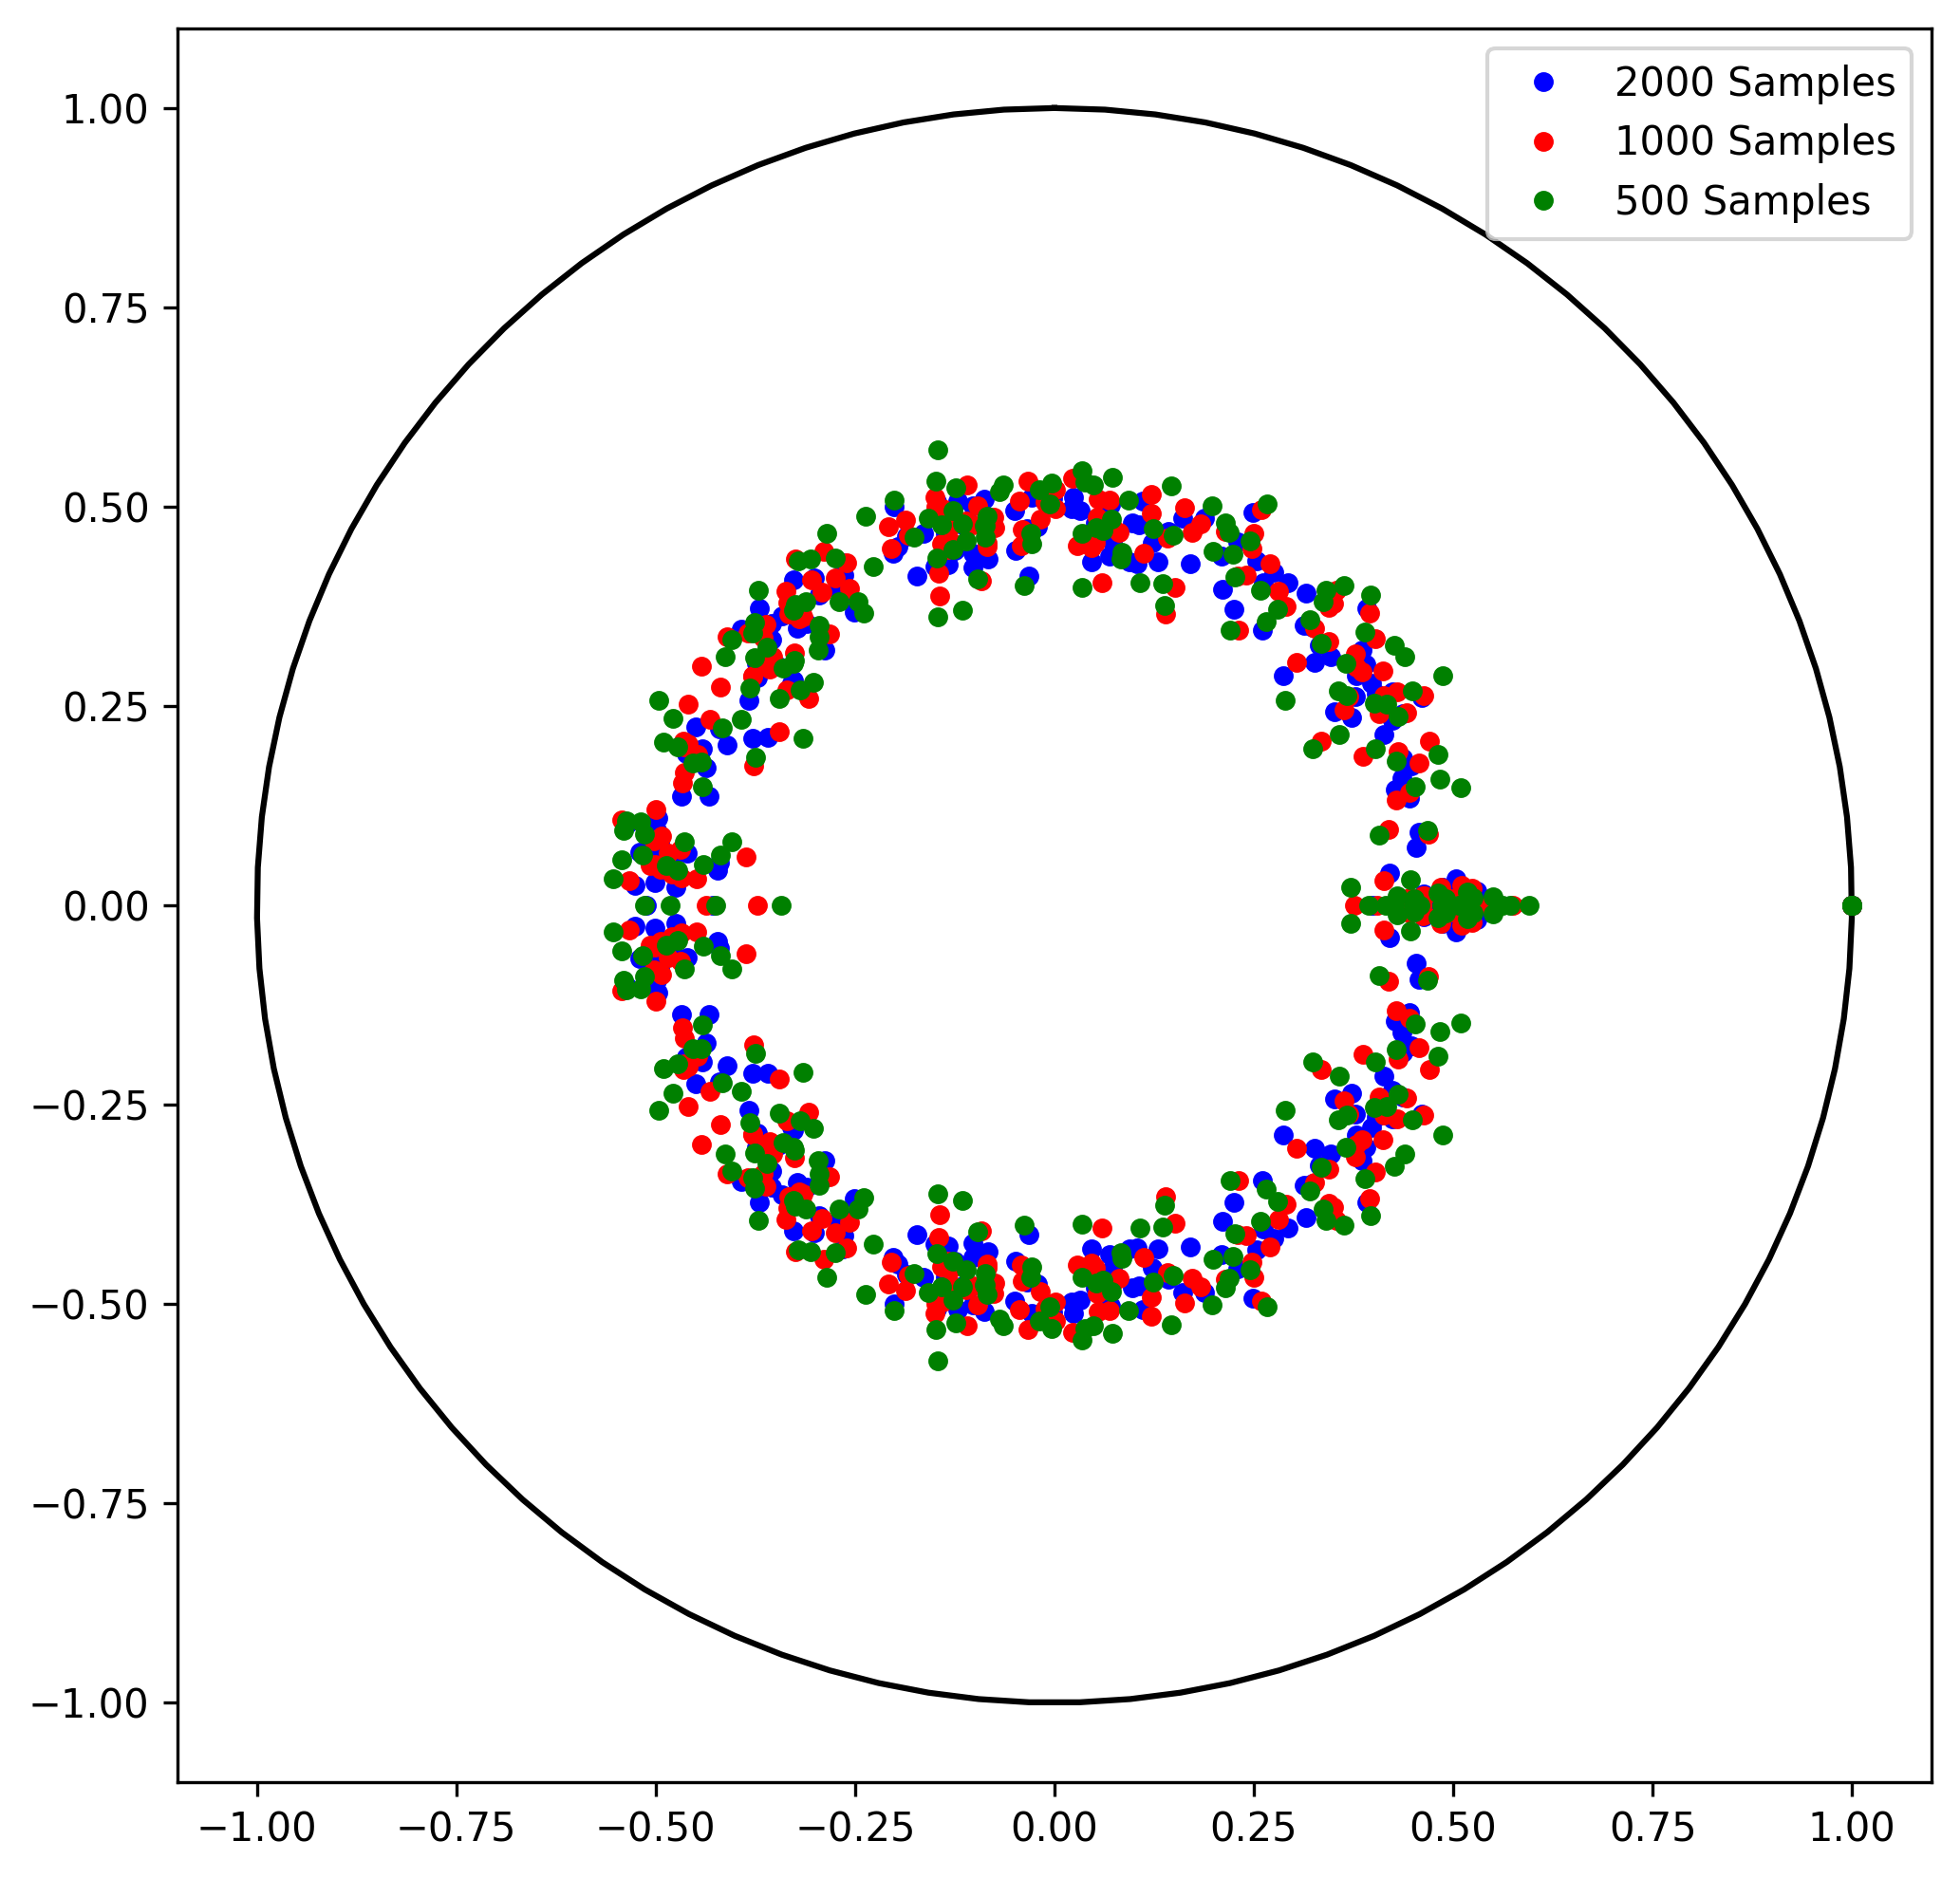

In [156]:
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(*spectrum_stab1, "bo", markersize=4)
plt.plot(*spectrum_stab2, "ro", markersize=4)
plt.plot(*spectrum_stab3, "go", markersize=4)

plt.legend(["_","2000 Samples", "1000 Samples", "500 Samples"])

#plt.legend(["_","No Delay","5$\mu$s Delay","10$\mu$s Delay", "15$\mu$s Delay","20$\mu$s Delay", "25$\mu$s Delay"], loc = "upper right")

plt.show()

## Concatentation

In [4]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model1 = fit_model("lima_concatenate0",  16)
model2 = fit_model("lima_concatenate1",  16)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0015061412306877908


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0038851482324423654 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001455118169158782


  0%|          | 0/4000 [00:00<?, ?it/s]

0.005974170488778111 None


In [ ]:
model12 = fit_model("lima_concatenate_full0",  16)

In [1]:
channel1 = model1.channel
channel2 = model2.channel
channel_full = model12.channel
channel_concat = channel_to_choi_map([channel1, channel2])

spectrum_concat = channel_spectrum(channel_concat, use_coords=True)
spectrum_full = channel_spectrum(channel_full, use_coords=True)

NameError: name 'model1' is not defined

In [2]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_concat[:,0], spectrum_concat[:,1], "bo")
plt.plot(spectrum_full[:,0], spectrum_full[:,1], "ro")

plt.show()

NameError: name 'np' is not defined

In [63]:
print(channel_fidelity(channel_full, channel_full))

tf.Tensor(1.0000001278469197, shape=(), dtype=float64)
